## KGB Model LN Auto V2 With LDA and Variable Reduction

In [1]:
!pip install xgboost


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import logging
import xgboost as xgb
import ast
import itertools
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2
import os
import sys

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

In [4]:
sys.path.append('/root/Unified_LN_V2/')
from Utilities import *

In [5]:
Train = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Train_Binned_Data_260324.csv')
Test = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Test_Binned_Data_260324.csv')
Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Oot_Binned_Data_260324.csv')
TTD= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Ttd_Binned_Data_260324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [6]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [7]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [8]:
Train[all_cols].head()

,unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
0,319468,Tower,2017-04-13,1.0,1.0,857.0,NaN,0.0,Auto,777.0,789.0,white,M,Age 62 and over,"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf

In [9]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum()})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum()})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum()})

{'Length': 146855.0, 'Bads': 2227.0}
{'Length': 62938.0, 'Bads': 959.0}
{'Length': 37121.0, 'Bads': 545.0}


In [10]:
Train.shape, Test.shape, Oot.shape

((146855, 145), (62938, 145), (37121, 144))

In [11]:
Train['wt2'].describe([0.9, 0.95, 0.99])

count    146855.000000
mean          1.669488
std           0.586060
min           1.060974
50%           1.487468
90%           2.326326
95%           2.722267
99%           3.905550
max          14.347176
Name: wt2, dtype: float64

In [12]:
Train.groupby('client')['wt2'].agg(['count', 'min', 'mean', 'max'])

,count,min,mean,max
client,,,,
Arkansas,27867,1.095290,1.583894,8.997074
Bethpage,8328,1.060974,1.453413,5.114712
CPM,6702,1.110488,1.601482,6.383648
GESA,19768,1.101697,1.810696,9.780985
Guardian,19177,1.101219,1.931245,13.497463
HFCU,2044,1.117645,1.662495,8.340647
Hawaii,1438,1.091428,1.775832,8.729644
NCU,595,1.142343,1.784662,5.058578
Numerica,18091,1.096292,1.770058,12.683987


In [13]:
Train= Train[all_cols + ['wt2']]
Test= Test[all_cols + ['wt2']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [14]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [15]:
var_to_cat= list(set(var_to_cat))
len(var_to_cat)

37

In [16]:
for var in var_to_cat:
    Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(str)]
    Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(str)]
    Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(str)]
    TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(str)]

In [17]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     141943
[1]       4543
[2]        337
[-1]        32
Name: count, dtype: int64
bankruptcystatus
[0]     60829
[1]      1941
[2]       157
[-1]       11
Name: count, dtype: int64
bankruptcystatus
[0]     35903
[1]      1132
[2]        84
[-1]        2
Name: count, dtype: int64
bankruptcystatus
[0]     648409
[1]      33203
[2]       3175
[-1]       428
Name: count, dtype: int64


In [18]:
Train[req_cols].isnull().sum()

assetpropevercount                 0
sourcenonderogcount06month         0
addronfilecount                    0
addrinputcountyratio               0
assetpropnewestsaleprice           0
addrcurrenttaxvalue                0
addrinputavmvalue                  0
addrinputavmvalue60month           0
addrinputlastsaleprice             0
addrinputtaxmarketvalue            0
sourcecredheadertimeoldest         0
addrinputphonecount                0
assetpropcurrenttaxtotal           0
addrcurrentavmvalue                0
assetproppurchasetimeoldest        0
addrpreviouslengthofres            0
addrinputlengthofres               0
addrcurrenttaxmarketvalue          0
addrprevioustimenewest             0
addrcurrenttractratio              0
sourcenonderogcount12month         0
assetpropcurrentcount              0
addrinputsubjectcount              0
sourcenonderogcount                0
addrinputtaxvalue                  0
assetpropeversoldcount             0
businessassociationtimeoldest      0
a

In [19]:
path_to_save= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/'

In [20]:
Train['funded_flag'].sum(), Train.shape, Train['bad_flag'].sum(), Train['bad_flag'].mean()

(146855.0, (146855, 145), 2227.0, 0.015164618160770828)

In [21]:
Test['funded_flag'].sum(), Test.shape, Test['bad_flag'].sum(), Test['bad_flag'].mean()

(62938.0, (62938, 145), 959.0, 0.015237217579204931)

In [22]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [23]:
df_bv= pd.DataFrame()

for col in req_cols:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                # p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_Count']#'Train_P1', 
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                # p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_Count']#'Test_P1', 
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
businesstitleleadership
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
proflic

In [24]:
df_bv.head()

,variable,Bucket,Train_BadCount,Train_BadRate,Train_Count,Test_BadCount,Test_BadRate,Test_Count,Is_Trend
0,assetpropevercount,"[-inf, 1.0)",1526.0,0.030046,50788,663.0,0.030656,21627.0,Yes
1,assetpropevercount,"[1.0, 2.0)",445.0,0.008564,51963,204.0,0.009101,22414.0,Yes
2,assetpropevercount,"[2.0, 3.0)",155.0,0.006657,23283,57.0,0.005765,9887.0,Yes
3,assetpropevercount,"[3.0, inf)",101.0,0.004851,20821,35.0,0.003885,9010.0,Yes
4,sourcenonderogcount06month,"[-inf, 2.0)",1793.0,0.021940,81723,760.0,0.021714,35000.0,Yes


In [25]:
var_trend_break= list(df_bv[(df_bv['Is_Trend']== 'No') & (~(df_bv['variable'].isin(var_to_cat)))]['variable'].unique())
var_trend_break, len(var_trend_break)

(['assetpropnewestsaleprice',
  'addrinputavmvalue60month',
  'addrinputlastsaleprice',
  'assetpropcurrenttaxtotal',
  'addrcurrenttractratio',
  'businessassociationtimeoldest',
  'derogtimenewest',
  'educationinstitutionprivate',
  'addrinputavmratio60monthprior',
  'addrcurrentcountyratio',
  'assetpropsaletimeoldest',
  'criminalnonfelonytimenewest',
  'addrcurrentlastsalesprice',
  'evictiontimenewest',
  'bankruptcycount',
  'addrinputtimeoldest',
  'addrcurrentavmratio60monthprior',
  'addrinputavmvalue12month',
  'assetpropsaletimenewest',
  'bankruptcytimenewest',
  'criminalfelonycount12month',
  'criminalfelonytimenewest',
  'lienjudgmentothercount',
  'lienjudgmenttimenewest',
  'sourcecredheadertimenewest'],
 25)

In [26]:
var_trend_break= ['assetpropnewestsaleprice',
  'addrinputavmvalue60month',
  'addrinputlastsaleprice',
  'assetpropcurrenttaxtotal',
  'addrcurrenttractratio',
  'businessassociationtimeoldest',
  'derogtimenewest',
  'educationinstitutionprivate',
  'addrinputavmratio60monthprior',
  'addrcurrentcountyratio',
  'assetpropsaletimeoldest',
  'criminalnonfelonytimenewest',
  'addrcurrentlastsalesprice',
  'evictiontimenewest',
  'bankruptcycount',
  'addrinputtimeoldest',
  'addrcurrentavmratio60monthprior',
  'addrinputavmvalue12month',
  'assetpropsaletimenewest',
  'bankruptcytimenewest',
  'criminalfelonycount12month',
  'criminalfelonytimenewest',
  'lienjudgmentothercount',
  'lienjudgmenttimenewest',
  'sourcecredheadertimenewest']
len(var_trend_break), len(list(set(var_trend_break)))

(25, 25)

### Base Model Weighted Auto Without Segmentation Without FLA, LDA

In [27]:
!pip install hyperopt


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [28]:
import numpy as np
import pandas as pd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import h2o
from h2o.estimators import H2OXGBoostEstimator
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
import warnings
warnings.filterwarnings('ignore')

In [29]:
### Starting H2o Session
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpj3c0suay
  JVM stdout: /tmp/tmpj3c0suay/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpj3c0suay/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_unknownUser_cn15y8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.486 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [30]:
Train['unique_id']= Train['unique_id'].astype(str)
Test['unique_id']= Test['unique_id'].astype(str)
Oot['unique_id']= Oot['unique_id'].astype(str)
TTD['unique_id']= TTD['unique_id'].astype(str)

In [31]:
train_h2o = h2o.H2OFrame(Train)
test_h2o = h2o.H2OFrame(Test)
oot_h2o= h2o.H2OFrame(Oot)
ttd_h2o= h2o.H2OFrame(TTD)
print(Train.shape,train_h2o.shape,Test.shape,test_h2o.shape, oot_h2o.shape, ttd_h2o.shape)
bad_col = 'bad_flag'
Train[bad_col].mean(),Test[bad_col].mean()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(146855, 145) (146855, 145) (62938, 145) (62938, 145) (37121, 144) (685215, 144)


(0.015164618160770828, 0.015237217579204931)

In [32]:
# for col in var_to_cat:
#     train_h2o[col] = train_h2o[col].asfactor()
#     test_h2o[col] = test_h2o[col].asfactor()
#     oot_h2o[col] = oot_h2o[col].asfactor()
#     ttd_h2o[col] = ttd_h2o[col].asfactor()

In [33]:
for k in Train['bankruptcychapter'].unique():
    print(k, train_h2o[train_h2o['bankruptcychapter']== k].shape)

[0] (141943, 145)
[1] (3731, 145)
[2] (1178, 145)
[-1] (3, 145)


In [34]:
train_h2o.head(rows= 2)

unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest,wt2
319468,Tower,2017-04-13 00:00:00,1,1,857,nan,0,Auto,777,789,white,M,Age 62 and over,"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf, 

In [35]:
train_h2o[req_cols].head(rows= 2)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf, 76843.0)","[-inf, 69000.0)","[0.0, inf)",[0],[1],[0],"[242.0, inf)","[-inf, 1.33)","[256476.0, 313290.0)",[0],[1],[0],[1],[1],[0],[0],[0],"[0.0, inf)",[1],"[247.0, inf)",[1],[1],[0],"[-inf, 0.203)",[1],[-1],"[-inf, 0.07

In [36]:
# for var in var_to_cat:
#     print(var, ttd_h2o[var].unique())

### Baseline

In [37]:
req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 130)

In [38]:
barsath_list_to_drop= '''addrinputavmvalue
addrinputphonecount
addrinputavmvalue12month
sourcevoterregistration
addrinputblockratio
addrinputcountyratio
educationinstitutionrating
addrcurrentavmvalue12month
addrinputavmvalue60month
addrlastmoveecontrajectory
addrcurrentavmvalue
businesstitleleadership
assetpropeversoldcount
addrprevioussubjectowned
addrinputtractratio
addrcurrentcountyratio
addrcurrentavmvalue60month
addrcurrentavmratio60monthprior
educationevidence
assetpersonal
proflictypecategory
addrprevioustimenewest'''.splitlines()
len(barsath_list_to_drop), len(list(set(barsath_list_to_drop)))

(22, 22)

In [39]:
unique_cols = ['unique_id', 'client']
wt_col = 'wt2'
folds = 10
# predictors = train_h2o.columns
req_cols = [var for var in req_cols if var not in barsath_list_to_drop + var_trend_break]
model_cols = unique_cols + [wt_col] + [bad_col] + req_cols
train_h2o[bad_col]= train_h2o[bad_col].asfactor()
len(req_cols)

87

In [40]:
train_h2o[req_cols].isna().sum()

0.0

### Run the Code

In [41]:
xgbm_auto_wt_segment_wt_lda_model = H2OXGBoostEstimator(
    ntrees=2000,    
    learn_rate=0.01,
    max_depth=2,    
    model_id="xgb_auto_wt_segment_with_lda_model",
    distribution = "bernoulli",    
    seed=42,
    nfolds = folds)#,    ignored_columns = unique_cols)

In [ ]:
%%time
xgbm_auto_wt_segment_wt_lda_model.train(y=bad_col, x= req_cols, training_frame=train_h2o, weights_column =wt_col)

xgboost Model Build progress: |███████████████████████████████████████████| (done) 100%
CPU times: user 11.3 s, sys: 749 ms, total: 12.1 s
Wall time: 53min 47s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgb_auto_wt_segment_with_lda_model


Model Summary: 
    number_of_trees
--  -----------------
    2000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.019853209552083414
RMSE: 0.14090141784979815
LogLoss: 0.08877961963581346
Mean Per-Class Error: 0.39704959501672354
AUC: 0.8038248806802077
AUCPR: 0.12179265057366373
Gini: 0.6076497613604155

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0834185855718474
       0       1     Error    Rate
-----  ------  ----  -------  ------------------
0      232835  7101  0.0296   (7101.0/239936.0)
1      4002    1232  0.7646   (4002.0/5234.0)
Total  236837  8333  0.0453   (11103.0/245170.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0834186    0.181708  134
max f2                       0.0485759    0.251465  202
max f0point5                 0.145326     0.185617  71
max accuracy                 0.330645     0.978897  11
max precision                0.660796     1         0
max recall                   0.00126931   1         398
max specificity              0.660796     1         0
max absolute_mcc             0.0557033    0.166004  186
max min_per_class_accuracy   0.0245747    0.721577  278
max mean_per_class_accuracy  0.0245747    0.722996  278
max tns                      0.660796     239937    0
max fns                      0.660796     5222.88   0
max fps                      0.00103261   239937    399
max tps                      0.00126931   5235.24   398
max tnr                      0.660796     1         0
max fnr                      0.660796     0.997639  0
max fpr                      0.00103261   1         399
max tpr                      0.00126931   1         398

Gains/Lift Table: Avg response rate:  2.28 %, avg score:  2.90 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0116105                   0.134739           9.94685    9.94685            0.226514         0.210739    0.226514                    0.210739            0.115487        0.115487                   894.685   894.685            0.106298
2        0.023542                    0.103213           5.44069    7.66304            0.123898         0.135166    0.174506                    0.172437            0.0649161       0.180404                   444.069   666.304            0.160517
3        0.0351193                   0.0869428          4.89319    6.74994            0.11143          0.110082    0.153713                    0.151881            0.0566496       0.237053                   389.319   574.994            0.20664
4        0.0465138                   0.0782754          3.73407    6.01114            0.085034         0.0984818   0.136888                    0.1388              0.042548        0.279601                   273.407   501.114            0.238519
5        0.0578031                   0.0721139          3.33814    5.48909            0.0760177        0.0902736   0.125                       0.129323            0.0376854       0.317287                   233.814   448.909            0.26553
6        0.113464                    0.050224           2.72134    4.13135            0.0619716        0.0740129   0.0940809                   0.10219             0.151471        0.468758                   172.134   313.135            0.363573
7        0.168205                    0.0359519         

##### Train Predictions

In [ ]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [ ]:
def get_risk_rank(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    print(pred[weight].sum(),((pred[weight]*pred[target]).sum()),pred[weight].max())

    data_ks_cap5= rnkOrderingN(pred, target, weight, score_col, 5, asc)
    display(data_ks_cap5[0])
    print(data_ks_cap5[1])
    # data_ks_cap10= rnkOrderingN(pred, target, weight, score_col, 10, asc)
    # display(data_ks_cap10[0])
    # print(data_ks_cap10[1])

#### Weighted

In [ ]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
245172.65465228388 5235.242054477501 14.3471756739957


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030157,0.660796,0.055164,49035.668531,45812.398032,3223.270498,6.57,20.0,19.09,61.57,42.48
1,0.017742,0.030157,0.023461,49034.498481,47927.430857,1107.067624,2.26,40.0,39.07,82.72,43.65
2,0.008407,0.017742,0.012361,49033.963753,48451.758243,582.205511,1.19,60.0,59.26,93.84,34.58
3,0.004471,0.008407,0.006179,49034.597927,48782.526758,252.071169,0.51,80.0,79.59,98.65,19.06
4,0.000545,0.004471,0.002945,49033.925959,48963.298708,70.627251,0.14,100.0,100.00,100.00,0.00


{'Gini': 55.910000000000004, 'KS': 43.65}


In [ ]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
105130.63232533663 2219.2405799159274 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030612,0.353437,0.055875,21026.619854,19747.052491,1279.567363,6.09,20.0,19.19,57.66,38.47
1,0.017903,0.030612,0.023641,21026.288533,20501.777680,524.510853,2.49,40.0,39.11,81.29,42.18
2,0.008424,0.017903,0.012426,21025.477359,20774.388195,251.089164,1.19,60.0,59.30,92.61,33.31
3,0.004442,0.008424,0.006174,21026.411444,20911.111384,115.300060,0.55,80.0,79.62,97.80,18.18
4,0.000553,0.004442,0.002926,21025.835135,20977.061994,48.773141,0.23,100.0,100.00,100.00,0.00


{'Gini': 52.86, 'KS': 42.18}


#### Non-weighted

In [ ]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
146855 2227.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024056,0.660796,0.044485,29372,28004.0,1368.0,4.66,20.0,19.36,61.43,42.07
1,0.012015,0.024055,0.017727,29370,28893.0,477.0,1.62,40.0,39.34,82.85,43.51
2,0.006407,0.012015,0.008723,29372,29118.0,254.0,0.86,60.0,59.47,94.25,34.78
3,0.003782,0.006407,0.005005,29371,29275.0,96.0,0.33,80.0,79.71,98.56,18.85
4,0.000545,0.003782,0.002593,29370,29338.0,32.0,0.11,100.0,100.00,100.00,0.00


{'Gini': 55.67999999999999, 'KS': 43.51}


In [ ]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024140,0.353437,0.044958,12588,12019.0,569.0,4.52,20.0,19.39,59.33,39.94
1,0.012064,0.024139,0.017813,12588,12365.0,223.0,1.77,40.0,39.34,82.59,43.25
2,0.006410,0.012063,0.008728,12587,12493.0,94.0,0.75,60.0,59.50,92.39,32.89
3,0.003743,0.006409,0.004982,12588,12540.0,48.0,0.38,80.0,79.73,97.39,17.66
4,0.000553,0.003743,0.002577,12587,12562.0,25.0,0.20,100.0,100.00,100.00,0.00


{'Gini': 53.5, 'KS': 43.25}


In [ ]:
Oot['wt2']= 1
TTD['wt2']= 1

In [ ]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
37121 545.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024096,0.471051,0.044656,7425,7112.0,313.0,4.22,20.0,19.44,57.43,37.99
1,0.012165,0.024096,0.017771,7424,7301.0,123.0,1.66,40.0,39.41,80.00,40.59
2,0.006408,0.012164,0.008806,7424,7357.0,67.0,0.90,60.0,59.52,92.29,32.77
3,0.003760,0.006408,0.004982,7424,7397.0,27.0,0.36,80.0,79.74,97.25,17.51
4,0.000561,0.003760,0.002601,7424,7409.0,15.0,0.20,100.0,100.00,100.00,0.00


{'Gini': 51.54, 'KS': 40.59}


In [ ]:
var_imp = xgbm_auto_wt_segment_wt_lda_model._model_json['output']['variable_importances'].as_data_frame()
var_imp['Var_unique'] = var_imp['variable'].str.split('.', expand=True)[0]
var_imp_list_baseline1 = list(var_imp['Var_unique'].unique())

print(var_imp_list_baseline1, len(var_imp_list_baseline1))

['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'derogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'addrinputtaxvalue', 'criminalnonfelonycount', 'evictioncount', 'derogcount12month', 'addrinputtimenewest', 'addrprevioustimeoldest', 'educationprogramattended', 'criminalfelonycount', 'educationattendance', 'addrinputlengthofres', 'addrcurrentblockratio', 'addrinputtaxmarketvalue', 'bankruptcydismissed24month', 'addrchangecount03month', 'inquirycollections12month', 'inquirybanking12month', 'bankruptcychapter', 'addrinputsubjectcount', 'addrchangecount24month', 'addrcurrentdeedmailing', 'addrinputdeedmailing', 'addrchangecount06month', 'lienjudgmentcount', 'lienjudgmentsmallclaimscount', 'addrpreviouslengthofres', 'bankruptcystatus', 'assetpropnewestmortgagetype', 'bankruptcycount24month', 'assetproppurchasetimeoldest', 'a

In [ ]:
var_imp

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,assetownership.[0],64166.105469,1.000000,0.187737,assetownership
1,inquiryauto12month.[0],63762.886719,0.993716,0.186557,inquiryauto12month
2,inquiryshortterm12month.[0],26209.839844,0.408469,0.076684,inquiryshortterm12month
3,"sourcenonderogcount12month.[-inf, 2.0)",22840.740234,0.355963,0.066827,sourcenonderogcount12month
4,"assetpropevercount.[-inf, 1.0)",16511.697266,0.257327,0.048310,assetpropevercount
5,inquirytelcom12month.[0],14869.912109,0.231741,0.043506,inquirytelcom12month
6,"sourcenonderogcount.[4.0, 5.0)",8787.505859,0.136949,0.025710,sourcenonderogcount
7,"sourcenonderogcount.[5.0, inf)",7652.057129,0.119254,0.022388,sourcenonderogcount
8,"derogcount.[-inf, 1.0)",7199.679199,0.112204,0.021065,derogcount
9,"addrlastmovetaxratiodiff.[-inf, 0.166)",6199.126953,0.096611,0.018137,addrlastmovetaxratiodiff


## HyperOpt

In [ ]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# test_h2o[bad_col] = test_h2o[bad_col].asfactor()
# oot_h2o[bad_col] = oot_h2o[bad_col].asfactor()
col_list = var_imp_list_baseline1
# len(col_list)
# 75
# col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'derogcount', 'addrlastmovetaxratiodiff', 'addrcurrenttaxmarketvalue', 'inquirynonshortterm12month', 'addrinputtaxvalue', 'criminalnonfelonycount', 'evictioncount', 'derogcount12month', 'addrinputtimenewest', 'educationinstitutionrating', 'addrprevioustimeoldest', 'addrcurrentavmvalue60month', 'addrcurrentavmvalue', 'criminalfelonycount', 'educationattendance', 'addrinputlengthofres', 'addrchangecount03month', 'inquirycollections12month', 'inquirybanking12month', 'bankruptcydismissed24month', 'addrlastmoveecontrajectory', 'addrchangecount24month', 'bankruptcychapter', 'addrinputtaxmarketvalue', 'bankruptcystatus', 'addrcurrentdeedmailing', 'addrinputdeedmailing', 'lienjudgmentcount', 'educationprogramattended', 'addrcurrentblockratio', 'addrchangecount06month', 'criminalnonfelonycount12month', 'addrpreviouslengthofres', 'bankruptcycount24month', 'lienjudgmenttaxcount', 'assetpropnewestmortgagetype', 'assetpersonalcount', 'lienjudgmentsmallclaimscount', 'addrprevioustimenewest', 'addrinputtimelastsale', 'addrcurrentlengthofres', 'assetproppurchasetimeoldest', 'sourcenonderogcount06month', 'lienjudgmentcourtcount', 'addrcurrenttimeoldest', 'addrinputtractratio', 'assetpropsalepurchaseratio', 'assetproppurchasetimenewest', 'businesstitleleadership', 'addrinputblockratio', 'addrchangecount60month', 'addrinputsubjectowned', 'subjectrecordtimeoldest', 'sourcecredheadertimeoldest', 'addrcurrentavmratio12monthprior', 'addrprevioussubjectowned', 'lienjudgmentcount12month', 'addronfilecount', 'addrcurrenttimenewest', 'assetpropcurrentcount', 'addronfilecollege', 'lienjudgmentdollartotal', 'shorttermloanrequest', 'addrcurrentsubjectowned', 'addrinputphoneservice', 'addrinputproblems', 'evictioncount12month', 'assetpropeversoldcount']
len(col_list)

67

In [ ]:
from IPython.display import clear_output


def get_predictions(data_h2o, bad_col, wt_col, classifier):
    predict = classifier.predict(data_h2o)
    p = predict.as_data_frame()
    dd = pd.DataFrame(data_h2o[:, unique_cols + [bad_col] + [wt_col] + ['age_cuts','Race','Gender']].as_data_frame())
    dd['RECWGT'] = dd[wt_col]
    dd['con_wt'] = 1
    dd['bad'] = dd[bad_col]
    pred = pd.concat([dd.loc[:, ('bad', "RECWGT", 'con_wt', 'age_cuts','Race','Gender')], p], axis=1)
    return pred


def find_cutoff(pred):
    sorted_pred = pred.sort_values(by='p1').reset_index(drop= True)
    cum_bad = sorted_pred['bad'].cumsum()
    bad_rate= sorted_pred['bad'].mean()
    cum_p1 = sorted_pred['p1'].cumsum()
    total_bad = cum_bad.iloc[-1]
#     total_bad= bad_rate
    cutoff_idx = (cum_p1 >= total_bad).idxmax()
    cutoff = sorted_pred.loc[cutoff_idx, 'p1']
    
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    print('Last Row')
    display(pd.DataFrame(sorted_pred.iloc[-1]).T)
    print('Cutoff Index Row')
    display(pd.DataFrame(sorted_pred.iloc[cutoff_idx]).T)
    
    print({'total_bad': total_bad, 'bad_rate': bad_rate, 'cutoff': cutoff, 'total_predicted': cum_p1.iloc[-1], 'max_prob': pred['p1'].max()})
    
    return cutoff

def Equal_Approval_Cutoff_Barsath(pred, target, score_col):
    pred= pred.copy()
    actual_approved_count= pred[target].sum()
    pred= pred.sort_values(by= [score_col])
    pred['con_wt']= 1
    pred['cumsum']= pred['con_wt'].cumsum()
    pred['approved']= np.where(pred['cumsum']<= actual_approved_count, 1, 0)
    return pred #cutoff, original_dataset

def find_cutoff_2(pred):
    pred= pred.copy()
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    prev_min = 1
    for k in range(1,100,1):
        pred["model_approval"] = [1 if i>k/100 else 0 for i in pred['p1']]
        a,b = pred.describe().loc['mean',['model_approval','bad']]
        if prev_min < abs(a-b):
            pred["model_approval"] = [1 if i>(k-1)/100 else 0 for i in pred['p1']]
            break
        else:
            prev_min = abs(a-b)
    print({'cutoff': (k-1)/100})
    return (k-1)/100

def air_calc(pred,prefix):
    air = {}
    target_control_dict = {
        'age_cuts': {
            'target': ['Age 62 and over'],
            'control': ['Age below 62']
        },
        'Race': {
            'target': ['black', 'hispanic'],
            'control': ['white']
        },
        'Race': {
            'target': ['black'],
            'control': ['white']
        },
        'Race': {
            'target': ['hispanic'],
            'control': ['white']
        },
        'Gender': {
            'target': ['F'],
            'control': ['M']
        },
        # 'mmct_tag': {
        #     'target': ['mmct'],
        #     'control': ['non-mmct']
        # }
    }
    
    for var in target_control_dict:
        target_list = target_control_dict[var]['target']
        control_list = target_control_dict[var]['control']
        p_target_list= ','.join(target_list)
        ttd_target= pred[pred[var].isin(target_list)]['con_wt'].sum()
        approved_target= pred[pred[var].isin(target_list)]['approved'].multiply(pred[pred[var].isin(target_list)]['con_wt']).sum()
        ttd_control= pred[pred[var].isin(control_list)]['con_wt'].sum()
        approved_control= pred[pred[var].isin(control_list)]['approved'].multiply(pred[pred[var].isin(control_list)]['con_wt']).sum()
        app_pct_target= round(approved_target/ttd_target, 4)
        app_pct_control= round(approved_control/ttd_control, 4)
        air[prefix+var+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
        print({'variable': var, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
               'approved_target': approved_target, 'approved_control': approved_control})
    print(air)
        
    return air

def air_calc_new(pred,prefix):
    air = {}
    target_control_dict = [
            {'age_cuts': {
                'target': ['Age 62 and over'],
                'control': ['Age below 62']
            }},
            {'Race': {
                'target': ['black', 'hispanic'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['black'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['hispanic'],
                'control': ['white']
            }},
            {'Gender': {
                'target': ['F'],
                'control': ['M']
            }},
            # 'mmct_tag': {
            #     'target': ['mmct'],
            #     'control': ['non-mmct']
            # }
    ]

    for var in target_control_dict:
        for i in var:
            target_list = var[i]['target']
            control_list = var[i]['control']
            p_target_list= ','.join(target_list) if (
                (len(target_list)<= 1) and (('black' in target_list) or ('hispanic' in target_list))
            ) else ''
            
            ttd_target= pred[pred[i].isin(target_list)]['con_wt'].sum()
            approved_target= pred[pred[i].isin(target_list)]['approved'].multiply(pred[pred[i].isin(target_list)]['con_wt']).sum()
            ttd_control= pred[pred[i].isin(control_list)]['con_wt'].sum()
            approved_control= pred[pred[i].isin(control_list)]['approved'].multiply(pred[pred[i].isin(control_list)]['con_wt']).sum()
            app_pct_target= round(approved_target/ttd_target, 4)
            app_pct_control= round(approved_control/ttd_control, 4)
            air[prefix+i+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
            print({'variable': i, 'target_list': p_target_list, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
                   'approved_target': approved_target, 'approved_control': approved_control})
            
    print(air)
        
    return air

In [ ]:
# TTD['ApproveCount'].value_counts(dropna= False)

In [ ]:
def get_prediction_2(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    
    return pred

In [ ]:
ttd_h2o[req_cols].head(rows= 5)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrcurrenttaxvalue,addrinputtaxmarketvalue,sourcecredheadertimeoldest,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,addrchangecount24month,addrinputtimelastsale,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,subjectrecordtimeoldest,addrcurrenttimenewest,lienjudgmentdollartotal,addrinputtimenewest,addrcurrenttimelastsale,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,businessassociation,criminalfelonycount,criminalnonfelonycount12month,derogcount12month,educationattendance,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,subjectnewestrecord12month,subjectrecordtimenewest
"[3.0, inf)","[2.0, inf)","[10.0, inf)","[-inf, 510.0)","[-inf, 4900.0)","[176.0, 253.0)","[29.0, 162.0)","[-inf, 23.0)","[113.0, 166.0)","[-inf, 9000.0)","[2.0, inf)","[2.0, inf)","[-inf, 1.0)","[5.0, inf)","[-inf, 518.0)","[-inf, 1.0)",[-1],"[98.0, 166.0)",[-1],"[0.11, 0.71)","[1.0, inf)","[-inf, 0.0454)","[253.0, 351.0)","[-inf, 4.755)","[683.805, inf)","[-inf, 2.581)",[-1],[-1],"[-inf, 0.0164)","[2.0, inf)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[0.0, inf)",[1],[0],[0],"[99.0, 165.0)",[-1],[1],[0],[0],[0],[0],[0],[0],"[0.0, inf)","[89.0, 136.0)",[1],[1],"[0.203, inf)",[1],[-1],"[-inf, 0.0742)","[-inf, 117.0)","[-inf, 0.145)","[-inf, 0.028)",[0],"[-inf, 0.00494)","[-inf, 0.000184)",[0],[0],"[-inf, 0.00304)","[-inf, 0.000926)","[-inf, 0.0141)",[0],[0],"[-inf, 0.00494)","[-inf, 0.000524)",[0],[1],[0],[1],[0],[0],"[0.101, inf)","[-inf, 0.0111)","[-inf, 0.0185)","[0.0, inf)","[-inf, 0.0169)","[0.0643, inf)",[0],[0],[0],[1],"[-inf, 1.605)"
"[3.0, inf)","[2.0, inf)","[-inf, 10.0)","[-inf, 510.0)","[-inf, 4900.0)","[253.0, 353.0)","[239.0, inf)","[87.0, 126.0)","[48.0, 113.0)","[-inf, 9000.0)","[2.0, inf)","[1.0, 2.0)","[1.0, 2.0)","[3.0, 4.0)","[-inf, 518.0)","[-inf, 1.0)",[-1],"[98.0, 166.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[253.0, 351.0)","[-inf, 4.755)","[-inf, 683.805)","[-inf, 2.581)",[-1],[-1],"[-inf, 0.0164)","[2.0, inf)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[0.0, inf)",[1],[0],[0],"[99.0, 165.0)","[-inf, 1.33)",[1],[0],[0],[0],[0],[0],[0],"[0.0, inf)","[89.0, 136.0)",[1],[1],"[-inf, 0.203)",[1],[-1],"[-inf, 0.0742)","[117.0, inf)","[0.145, inf)","[0.028, inf)",[0],"[-inf, 0.00494)","[-inf, 0.000184)",[0],[1],"[-inf, 0.00304)","[-inf, 0.000926)","[-inf, 0.0141)",[0],[0],"[-inf, 0.00494)","[-inf, 0.000524)",[0],[0],[0],[0],[0],[0],"[-inf, 0.101)","[-inf, 0.0111)","[-inf, 0.0185)","[0.0, inf)","[-inf, 0.0169)","[-inf, 0.0643)",[0],[0],[0],[1],"[-inf, 1.605)"
"[3.0, inf)","[2.0, inf)","[-inf, 10.0)","[510.0

In [ ]:
def objective(space):
    from sklearn.metrics import roc_auc_score
    classifier = H2OXGBoostEstimator(ntrees= int(space['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = space['learning_rate'],
                            min_rows = space['min_child_weight'],
                            sample_rate = space['subsample'],
                            colsample_bylevel = space['colsample_bylevel'],
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'],
                            min_split_improvement = space['gamma'],
                            colsample_bytree = space['colsample_bytree'],
                            model_id="xgbm_kgb_auto_ln_v2_1",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)
    h2o.no_progress()
    classifier.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )
    h2o.show_progress()
    pred = get_prediction_2(model= classifier, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
    train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    pred = get_prediction_2(model= classifier, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
    test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']
    
    pred = get_prediction_2(model= classifier, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
    # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    print('*'*15, ' TTD ', '*'*15)
    pred= get_prediction_2(model= classifier, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    air_ttd = air_calc_new(pred,'AIR ttd ')

    KS_diff = abs(train_ks-test_ks)
    gini_diff = abs(train_gini-test_gini)
    ks_diff_nw = abs(train_ks_cw-test_ks_cw)
    gini_diff_nw = abs(train_gini_cw-test_gini_cw)
    
    ks_diff_normal= (ks_diff_nw)/15
    ks_normal= (test_ks_cw - 20)/(40-20)
    auc_diff = abs(auc_train-auc_test)#/((auc_train+auc_test)/2)
    Stability = auc_diff
    Accuracy = (1-auc_test)
    Fairness_Race = 1-air_ttd['AIR ttd Race'][0]
    loss= (auc_diff*0.3) + ((1-auc_test)*0.2) + ((1-air_ttd['AIR ttd Race'][0])*0.5)
    # loss= KS_diff
    
    metrics = {'loss': [loss], 'KS_diff': [KS_diff], 'KS diff non-wt': [ks_diff_nw],
                   'GINI dif': [gini_diff], 'GINI diff non-wt': [gini_diff_nw],
                   'KS train wt': [train_ks], 'KS train non-wt': [train_ks_cw],
                   'KS test wt': [test_ks], 'KS test non-wt': [test_ks_cw],
                #    'KS oot wt': [oot_ks], 
               'KS oot non-wt': [oot_ks_cw],
#                    'AIR train': [air_tr], 'AIR test': [air_te], #'AIR oot': [air_oo],
                     'AIR ttd': [air_ttd],
               'AUC train':[auc_train], 'AUC test':[auc_test], #'AUC oot':[auc_oot]
    #                'Approval train target': [app_pct_target_tr], 'Approval train control': [app_pct_control_tr],
    #                'Approval test target': [app_pct_target_te], 'Approval test control': [app_pct_control_te],
    #                'Approval oot target': [app_pct_target_oo], 'Approval oot control': [app_pct_control_oo]
                  }
#     metrics.update(air_tr)
#     metrics.update(air_te)
    # metrics.update(air_oo)
    metrics.update(air_ttd)

    # clear previous output
#     clear_output(wait=True)
#     metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics)])
    # display(pd.DataFrame(metrics))
#     print(f'{loss}= ({auc_diff}*0.3) + ((1-{auc_test})*0.2) + ((1-{air_ttd["AIR ttd Race"][0]})*0.5))')
                
    return_dict =  {'loss': loss, 'status': STATUS_OK ,
           'KS_diff':KS_diff,'train_ks':train_ks,'test_ks':test_ks,#'oot_ks':oot_ks, 
           'gini_diff':gini_diff,'train_gini':train_gini,'test_gini':test_gini,#'oot_gini':oot_gini,
           'KS_cw_diff':ks_diff_nw,'train_ks_cw':train_ks_cw,'test_ks_cw':test_ks_cw,'oot_ks_cw':oot_ks_cw,
           'gini_diff_nw':gini_diff_nw,'train_gini_cw':train_gini_cw,'test_gini_cw':test_gini_cw,'oot_gini_cw':oot_gini_cw,
#            'AIR_train': air_tr, 'AIR_test': air_te, 'AIR_oot': air_oo, 'AIR ttd': air_ttd,
            'AUC train':auc_train,'AUC test':auc_test,'AUC oot':auc_oot,
             'Stability':Stability, 'Accuracy':Accuracy, 'Fairness_Race':Fairness_Race
            }
#     return_dict.update({k: v[0] for k, v in air_tr.items()})
#     return_dict.update({k: v[0] for k, v in air_te.items()})
    # return_dict.update({k: v[0] for k, v in air_oo.items()})
    return_dict.update({k: v[0] for k, v in air_ttd.items()})
    print(return_dict)
    print()
    return return_dict

In [ ]:
# space = {
#     'max_depth' : 2,#hp.choice('max_depth', range(1, 3, 1)),
#     'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.01),
#     'n_estimators' : ho_scope.int(hp.quniform('n_estimators',500,3000,100)),    
#     'min_child_weight' : hp.quniform('min_child_weight', 20, 150, 20),
#     'subsample' : hp.quniform('subsample', 0.4,1,0.1),
#     'colsample_bytree' : 1,#hp.quniform('colsample_bytree', 0.4, 1, 0.1),
#     'reg_lambda': hp.quniform('reg_lambda',1,20,0.5),
#     'reg_alpha': hp.quniform('reg_alpha',0,20,0.5),
#         'gamma':hp.quniform('gamma',0,20,0.25),
#             'colsample_bylevel':hp.quniform('colsample_bylevel',0.4, 1, 0.1)}

In [ ]:
space = {
    'max_depth' :2, #  hp.choice('max_depth', range(2, 3, 1)),
    'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.001),
    'n_estimators' : ho_scope.int(hp.quniform('n_estimators',800,2500,100)),
    'min_child_weight' : hp.quniform('min_child_weight', 25, 300, 5),
    'subsample' : hp.quniform('subsample', 0.1, 0.6, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'reg_lambda':  hp.quniform('reg_lambda',5,30,0.5),
    'reg_alpha': hp.quniform('reg_alpha',1,15,0.5),
    'gamma':hp.quniform('gamma',5,35,0.5),
    'colsample_bylevel':hp.quniform('colsample_bylevel',0.5, 1, 0.05),
#     'seed':42
}

In [ ]:
trials = Trials()

In [ ]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=120,
            trials=trials)

print("Best: ", best)

xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
***************                                        
 TTD                                                   
***************                                        
xgboost prediction progress: |                         
█                                                      
██████████████████████████████████████████████████| (done) 100%
  0%|          | 0/120 [03:15<?, ?trial/s, best loss=?]

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021843,0.026296,0.003369,0.006073,0.01268,0.026158,0.330004


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61767, 'approved_control': 339328}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52182, 'approved_control': 250817}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28556, 'approved_control': 250817}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23626, 'approved_control': 250817}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148559, 'approved_control': 229801}
{'AIR ttd age_cuts': [1.4676], 'AIR ttd Race': [0.6926], 'AIR ttd Raceblack': [0.7213], 'AIR ttd Racehispanic': [0.6608], 'AIR ttd Gender': [0.9287]}
{'loss': 0.20127057557172343, 'status': 'ok', 'KS_diff': 0.4200000000000017, 'train_ks': 40.07, 'test_ks': 40.49, 'gini_diff': 1.279999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022188,0.026653,0.002585,0.006299,0.012992,0.026762,0.341176


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61459, 'approved_control': 339614}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51859, 'approved_control': 251195}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28413, 'approved_control': 251195}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23446, 'approved_control': 251195}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149351, 'approved_control': 228999}
{'AIR ttd age_cuts': [1.4592], 'AIR ttd Race': [0.6873], 'AIR ttd Raceblack': [0.7166], 'AIR ttd Racehispanic': [0.6548], 'AIR ttd Gender': [0.9371]}
{'loss': 0.20366230983410163, 'status': 'ok', 'KS_diff': 0.240000000000002, 'train_ks': 41.01, 'test_ks': 41.25, 'gini_diff': 1.6300000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022168,0.027999,0.002759,0.006468,0.01298,0.025497,0.493124


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61807, 'approved_control': 339276}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51852, 'approved_control': 251141}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28476, 'approved_control': 251141}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23376, 'approved_control': 251141}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149458, 'approved_control': 228928}
{'AIR ttd age_cuts': [1.4687], 'AIR ttd Race': [0.6873], 'AIR ttd Raceblack': [0.7184], 'AIR ttd Racehispanic': [0.653], 'AIR ttd Gender': [0.9381]}
{'loss': 0.20365034333114138, 'status': 'ok', 'KS_diff': 0.01999999999999602, 'train_ks': 41.21, 'test_ks': 41.23, 'gini_diff': 1.600000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022194,0.030447,0.000832,0.005377,0.012668,0.02628,0.750858


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61304, 'approved_control': 339720}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51338, 'approved_control': 251229}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28638, 'approved_control': 251229}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22700, 'approved_control': 251229}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150588, 'approved_control': 227646}
{'AIR ttd age_cuts': [1.4551], 'AIR ttd Race': [0.6802], 'AIR ttd Raceblack': [0.7222], 'AIR ttd Racehispanic': [0.6338], 'AIR ttd Gender': [0.9504]}
{'loss': 0.20970365840538432, 'status': 'ok', 'KS_diff': 2.309999999999995, 'train_ks': 43.23, 'test_ks': 40.92, 'gini_diff': 3.7000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02177,0.026653,0.001393,0.005749,0.012636,0.026484,0.328416


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61329, 'approved_control': 339750}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51101, 'approved_control': 252061}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28264, 'approved_control': 252061}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22837, 'approved_control': 252061}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149496, 'approved_control': 228904}
{'AIR ttd age_cuts': [1.4554], 'AIR ttd Race': [0.675], 'AIR ttd Raceblack': [0.7104], 'AIR ttd Racehispanic': [0.6356], 'AIR ttd Gender': [0.9383]}
{'loss': 0.21065947125114065, 'status': 'ok', 'KS_diff': 0.04999999999999716, 'train_ks': 41.76, 'test_ks': 41.71, 'gini_diff': 1.829999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021897,0.028082,0.000767,0.005081,0.012277,0.02684,0.374415


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61685, 'approved_control': 339380}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51459, 'approved_control': 251362}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28778, 'approved_control': 251362}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22681, 'approved_control': 251362}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 151185, 'approved_control': 227096}
{'AIR ttd age_cuts': [1.4656], 'AIR ttd Race': [0.6816], 'AIR ttd Raceblack': [0.7254], 'AIR ttd Racehispanic': [0.6331], 'AIR ttd Gender': [0.9565]}
{'loss': 0.20744868889729406, 'status': 'ok', 'KS_diff': 1.3499999999999943, 'train_ks': 42.48, 'test_ks': 41.13, 'gini_diff': 2.619999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022365,0.027583,0.001204,0.005606,0.012813,0.027601,0.355383


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61190, 'approved_control': 339880}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51335, 'approved_control': 251566}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28544, 'approved_control': 251566}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22791, 'approved_control': 251566}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150327, 'approved_control': 227970}
{'AIR ttd age_cuts': [1.4516], 'AIR ttd Race': [0.6794], 'AIR ttd Raceblack': [0.7188], 'AIR ttd Racehispanic': [0.6357], 'AIR ttd Gender': [0.9474]}
{'loss': 0.20796527834618853, 'status': 'ok', 'KS_diff': 0.8900000000000006, 'train_ks': 42.44, 'test_ks': 41.55, 'gini_diff': 1.920000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022034,0.025981,0.003872,0.006883,0.013625,0.025544,0.488427


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61639, 'approved_control': 339465}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52224, 'approved_control': 250904}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28491, 'approved_control': 250904}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23733, 'approved_control': 250904}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149309, 'approved_control': 229048}
{'AIR ttd age_cuts': [1.464], 'AIR ttd Race': [0.693], 'AIR ttd Raceblack': [0.7195], 'AIR ttd Racehispanic': [0.6636], 'AIR ttd Gender': [0.9365]}
{'loss': 0.20072861962545308, 'status': 'ok', 'KS_diff': 0.3399999999999963, 'train_ks': 40.71, 'test_ks': 41.05, 'gini_diff': 1.37000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022007,0.029545,0.000445,0.00491,0.012308,0.026784,0.571824


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61746, 'approved_control': 339225}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51173, 'approved_control': 251410}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28820, 'approved_control': 251410}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22353, 'approved_control': 251410}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 151069, 'approved_control': 227230}
{'AIR ttd age_cuts': [1.4676], 'AIR ttd Race': [0.6777], 'AIR ttd Raceblack': [0.7264], 'AIR ttd Racehispanic': [0.6238], 'AIR ttd Gender': [0.9552]}
{'loss': 0.2122887832578377, 'status': 'ok', 'KS_diff': 2.719999999999999, 'train_ks': 44.25, 'test_ks': 41.53, 'gini_diff': 4.32, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022327,0.024926,0.003384,0.006436,0.012726,0.028004,0.203629


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60327, 'approved_control': 340768}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51531, 'approved_control': 251837}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28387, 'approved_control': 251837}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23144, 'approved_control': 251837}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148819, 'approved_control': 229755}
{'AIR ttd age_cuts': [1.4275], 'AIR ttd Race': [0.6813], 'AIR ttd Raceblack': [0.7142], 'AIR ttd Racehispanic': [0.6448], 'AIR ttd Gender': [0.9305]}
{'loss': 0.2064311633851466, 'status': 'ok', 'KS_diff': 0.4000000000000057, 'train_ks': 39.84, 'test_ks': 39.44, 'gini_diff': 0.0800000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022268,0.023832,0.004446,0.006945,0.013341,0.026937,0.168445


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61112, 'approved_control': 339916}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51753, 'approved_control': 251607}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28490, 'approved_control': 251607}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23263, 'approved_control': 251607}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148542, 'approved_control': 230046}
{'AIR ttd age_cuts': [1.4497], 'AIR ttd Race': [0.6847], 'AIR ttd Raceblack': [0.7174], 'AIR ttd Racehispanic': [0.6485], 'AIR ttd Gender': [0.9277]}
{'loss': 0.204135192290757, 'status': 'ok', 'KS_diff': 0.20999999999999375, 'train_ks': 39.66, 'test_ks': 39.45, 'gini_diff': 0.0399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022706,0.024099,0.003744,0.006688,0.014737,0.027355,0.175223


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61653, 'approved_control': 339421}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54299, 'approved_control': 248898}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29284, 'approved_control': 248898}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25015, 'approved_control': 248898}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147116, 'approved_control': 231338}
{'AIR ttd age_cuts': [1.4646], 'AIR ttd Race': [0.7262], 'AIR ttd Raceblack': [0.7455], 'AIR ttd Racehispanic': [0.7051], 'AIR ttd Gender': [0.9137]}
{'loss': 0.1847255773219314, 'status': 'ok', 'KS_diff': 0.980000000000004, 'train_ks': 38.26, 'test_ks': 39.24, 'gini_diff': 1.28000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022311,0.027268,0.001392,0.005719,0.012713,0.027815,0.332778


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60861, 'approved_control': 340260}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51345, 'approved_control': 251879}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28368, 'approved_control': 251879}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22977, 'approved_control': 251879}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149397, 'approved_control': 228893}
{'AIR ttd age_cuts': [1.4422], 'AIR ttd Race': [0.6786], 'AIR ttd Raceblack': [0.7136], 'AIR ttd Racehispanic': [0.6398], 'AIR ttd Gender': [0.9376]}
{'loss': 0.20875923808527633, 'status': 'ok', 'KS_diff': 0.10000000000000142, 'train_ks': 42.07, 'test_ks': 41.97, 'gini_diff': 1.78999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022554,0.028086,0.000866,0.005515,0.012921,0.02794,0.396334


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62139, 'approved_control': 338910}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51749, 'approved_control': 250992}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29082, 'approved_control': 250992}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22667, 'approved_control': 250992}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150424, 'approved_control': 227762}
{'AIR ttd age_cuts': [1.4782], 'AIR ttd Race': [0.6864], 'AIR ttd Raceblack': [0.7341], 'AIR ttd Racehispanic': [0.6335], 'AIR ttd Gender': [0.9489]}
{'loss': 0.20452778654216522, 'status': 'ok', 'KS_diff': 0.7899999999999991, 'train_ks': 42.12, 'test_ks': 41.33, 'gini_diff': 2.560000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022024,0.025076,0.002738,0.006715,0.013333,0.026721,0.309351


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61425, 'approved_control': 339598}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51810, 'approved_control': 251025}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28679, 'approved_control': 251025}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23131, 'approved_control': 251025}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149409, 'approved_control': 228904}
{'AIR ttd age_cuts': [1.4585], 'AIR ttd Race': [0.6872], 'AIR ttd Raceblack': [0.7239], 'AIR ttd Racehispanic': [0.6464], 'AIR ttd Gender': [0.9378]}
{'loss': 0.2033139936358788, 'status': 'ok', 'KS_diff': 0.3400000000000034, 'train_ks': 41.4, 'test_ks': 41.74, 'gini_diff': 1.10000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02196,0.023493,0.004388,0.006968,0.013346,0.026293,0.17961


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61163, 'approved_control': 339914}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51811, 'approved_control': 251460}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28478, 'approved_control': 251460}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23333, 'approved_control': 251460}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148797, 'approved_control': 229672}
{'AIR ttd age_cuts': [1.4509], 'AIR ttd Race': [0.6859], 'AIR ttd Raceblack': [0.7175], 'AIR ttd Racehispanic': [0.6509], 'AIR ttd Gender': [0.9308]}
{'loss': 0.20374206710619702, 'status': 'ok', 'KS_diff': 0.4399999999999977, 'train_ks': 39.94, 'test_ks': 39.5, 'gini_diff': 0.3700000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022247,0.030245,0.000668,0.005118,0.012427,0.026655,0.710216


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60935, 'approved_control': 340062}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50808, 'approved_control': 251755}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28602, 'approved_control': 251755}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22206, 'approved_control': 251755}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150987, 'approved_control': 227156}
{'AIR ttd age_cuts': [1.4448], 'AIR ttd Race': [0.6718], 'AIR ttd Raceblack': [0.7198], 'AIR ttd Racehispanic': [0.6188], 'AIR ttd Gender': [0.9549]}
{'loss': 0.21388962716899734, 'status': 'ok', 'KS_diff': 2.4200000000000017, 'train_ks': 44.04, 'test_ks': 41.62, 'gini_diff': 3.280000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02189,0.026277,0.001979,0.006055,0.012694,0.026915,0.384695


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61491, 'approved_control': 339596}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51980, 'approved_control': 251043}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28785, 'approved_control': 251043}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23195, 'approved_control': 251043}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149891, 'approved_control': 228407}
{'AIR ttd age_cuts': [1.4599], 'AIR ttd Race': [0.6892], 'AIR ttd Raceblack': [0.7264], 'AIR ttd Racehispanic': [0.6482], 'AIR ttd Gender': [0.9427]}
{'loss': 0.20252572737704183, 'status': 'ok', 'KS_diff': 0.259999999999998, 'train_ks': 41.07, 'test_ks': 40.81, 'gini_diff': 1.5200000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02216,0.025796,0.00185,0.005769,0.012996,0.028235,0.299172


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60476, 'approved_control': 340495}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52024, 'approved_control': 250547}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28819, 'approved_control': 250547}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23205, 'approved_control': 250547}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150299, 'approved_control': 227900}
{'AIR ttd age_cuts': [1.4321], 'AIR ttd Race': [0.6912], 'AIR ttd Raceblack': [0.7288], 'AIR ttd Racehispanic': [0.6498], 'AIR ttd Gender': [0.9475]}
{'loss': 0.2032714846470375, 'status': 'ok', 'KS_diff': 0.5300000000000011, 'train_ks': 41.01, 'test_ks': 40.48, 'gini_diff': 1.4399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02212,0.024547,0.00345,0.006899,0.013678,0.026872,0.281725


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61257, 'approved_control': 339781}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51980, 'approved_control': 250872}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28500, 'approved_control': 250872}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23480, 'approved_control': 250872}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149059, 'approved_control': 229260}
{'AIR ttd age_cuts': [1.4536], 'AIR ttd Race': [0.6898], 'AIR ttd Raceblack': [0.7198], 'AIR ttd Racehispanic': [0.6567], 'AIR ttd Gender': [0.9341]}
{'loss': 0.20236622615642502, 'status': 'ok', 'KS_diff': 0.10999999999999943, 'train_ks': 41.1, 'test_ks': 41.21, 'gini_diff': 0.829999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021961,0.026138,0.002249,0.005881,0.012394,0.027002,0.266996


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60926, 'approved_control': 340214}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52065, 'approved_control': 250881}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28697, 'approved_control': 250881}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23368, 'approved_control': 250881}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149754, 'approved_control': 228486}
{'AIR ttd age_cuts': [1.4439], 'AIR ttd Race': [0.6909], 'AIR ttd Raceblack': [0.7247], 'AIR ttd Racehispanic': [0.6533], 'AIR ttd Gender': [0.9416]}
{'loss': 0.20217027637260324, 'status': 'ok', 'KS_diff': 0.07000000000000028, 'train_ks': 40.87, 'test_ks': 40.94, 'gini_diff': 1.39000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022804,0.027886,0.001724,0.006157,0.013054,0.027767,0.377938


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61237, 'approved_control': 339874}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51627, 'approved_control': 251485}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28233, 'approved_control': 251485}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23394, 'approved_control': 251485}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149332, 'approved_control': 229022}
{'AIR ttd age_cuts': [1.4527], 'AIR ttd Race': [0.6835], 'AIR ttd Raceblack': [0.7112], 'AIR ttd Racehispanic': [0.6526], 'AIR ttd Gender': [0.9368]}
{'loss': 0.20645784877520817, 'status': 'ok', 'KS_diff': 0.3200000000000003, 'train_ks': 41.57, 'test_ks': 41.25, 'gini_diff': 1.649999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021969,0.027276,0.002575,0.006291,0.012467,0.025956,0.390379


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61835, 'approved_control': 339286}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52326, 'approved_control': 250646}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28760, 'approved_control': 250646}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23566, 'approved_control': 250646}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149756, 'approved_control': 228494}
{'AIR ttd age_cuts': [1.4695], 'AIR ttd Race': [0.6949], 'AIR ttd Raceblack': [0.7269], 'AIR ttd Racehispanic': [0.6595], 'AIR ttd Gender': [0.9416]}
{'loss': 0.19926712561672213, 'status': 'ok', 'KS_diff': 0.10999999999999943, 'train_ks': 40.97, 'test_ks': 41.08, 'gini_diff': 1.07999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022245,0.02602,0.003185,0.006206,0.012525,0.02685,0.267808


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61121, 'approved_control': 339967}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51865, 'approved_control': 251133}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28499, 'approved_control': 251133}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23366, 'approved_control': 251133}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148951, 'approved_control': 229443}
{'AIR ttd age_cuts': [1.4496], 'AIR ttd Race': [0.6876], 'AIR ttd Raceblack': [0.719], 'AIR ttd Racehispanic': [0.6527], 'AIR ttd Gender': [0.9327]}
{'loss': 0.20386415949475217, 'status': 'ok', 'KS_diff': 0.030000000000001137, 'train_ks': 40.31, 'test_ks': 40.34, 'gini_diff': 1.36000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022092,0.024643,0.003757,0.006138,0.012694,0.027396,0.173615


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60436, 'approved_control': 340579}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51268, 'approved_control': 251953}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28243, 'approved_control': 251953}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23025, 'approved_control': 251953}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147994, 'approved_control': 230678}
{'AIR ttd age_cuts': [1.4308], 'AIR ttd Race': [0.6774], 'AIR ttd Raceblack': [0.7102], 'AIR ttd Racehispanic': [0.6411], 'AIR ttd Gender': [0.9217]}
{'loss': 0.20846155330726737, 'status': 'ok', 'KS_diff': 0.060000000000002274, 'train_ks': 39.28, 'test_ks': 39.34, 'gini_diff': 0.0900000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021769,0.025738,0.003143,0.006173,0.012194,0.026235,0.2811


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59946, 'approved_control': 341147}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51252, 'approved_control': 251805}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28298, 'approved_control': 251805}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22954, 'approved_control': 251805}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149681, 'approved_control': 228613}
{'AIR ttd age_cuts': [1.4166], 'AIR ttd Race': [0.6776], 'AIR ttd Raceblack': [0.7119], 'AIR ttd Racehispanic': [0.6394], 'AIR ttd Gender': [0.9406]}
{'loss': 0.20893505869436074, 'status': 'ok', 'KS_diff': 0.23000000000000398, 'train_ks': 40.6, 'test_ks': 40.37, 'gini_diff': 0.760000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021447,0.00898,0.012291,0.013184,0.020863,0.024001,0.041723


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61455, 'approved_control': 338967}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52614, 'approved_control': 249734}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28388, 'approved_control': 249734}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24226, 'approved_control': 249734}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147935, 'approved_control': 230179}
{'AIR ttd age_cuts': [1.4618], 'AIR ttd Race': [0.7013], 'AIR ttd Raceblack': [0.7202], 'AIR ttd Racehispanic': [0.6805], 'AIR ttd Gender': [0.9233]}
{'loss': 0.20024800465576534, 'status': 'ok', 'KS_diff': 1.5399999999999991, 'train_ks': 36.37, 'test_ks': 37.91, 'gini_diff': 0.370000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021754,0.025196,0.002407,0.006237,0.01255,0.026686,0.290159


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60298, 'approved_control': 340756}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51513, 'approved_control': 251222}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28540, 'approved_control': 251222}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22973, 'approved_control': 251222}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149894, 'approved_control': 228488}
{'AIR ttd age_cuts': [1.4268], 'AIR ttd Race': [0.6825], 'AIR ttd Raceblack': [0.7197], 'AIR ttd Racehispanic': [0.6415], 'AIR ttd Gender': [0.9424]}
{'loss': 0.20620802950170336, 'status': 'ok', 'KS_diff': 0.4199999999999946, 'train_ks': 40.38, 'test_ks': 40.8, 'gini_diff': 0.6399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022317,0.022989,0.004498,0.007024,0.014278,0.02776,0.214885


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61329, 'approved_control': 339758}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52177, 'approved_control': 250728}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28517, 'approved_control': 250728}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23660, 'approved_control': 250728}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149102, 'approved_control': 229256}
{'AIR ttd age_cuts': [1.4554], 'AIR ttd Race': [0.6927], 'AIR ttd Raceblack': [0.7206], 'AIR ttd Racehispanic': [0.662], 'AIR ttd Gender': [0.9344]}
{'loss': 0.20123063212012174, 'status': 'ok', 'KS_diff': 0.020000000000003126, 'train_ks': 40.33, 'test_ks': 40.35, 'gini_diff': 0.97999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022178,0.023902,0.004846,0.007423,0.014178,0.026648,0.291827


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61837, 'approved_control': 339273}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52390, 'approved_control': 250645}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28488, 'approved_control': 250645}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23902, 'approved_control': 250645}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148747, 'approved_control': 229613}
{'AIR ttd age_cuts': [1.4695], 'AIR ttd Race': [0.6958], 'AIR ttd Raceblack': [0.72], 'AIR ttd Racehispanic': [0.669], 'AIR ttd Gender': [0.9306]}
{'loss': 0.1994547318686866, 'status': 'ok', 'KS_diff': 0.2700000000000031, 'train_ks': 40.04, 'test_ks': 40.31, 'gini_diff': 1.0, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022379,0.030818,0.00037,0.00469,0.01243,0.026991,0.757854


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60994, 'approved_control': 339964}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50817, 'approved_control': 251814}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28600, 'approved_control': 251814}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22217, 'approved_control': 251814}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150435, 'approved_control': 227757}
{'AIR ttd age_cuts': [1.4467], 'AIR ttd Race': [0.6718], 'AIR ttd Raceblack': [0.7196], 'AIR ttd Racehispanic': [0.6189], 'AIR ttd Gender': [0.9489]}
{'loss': 0.2151654578737516, 'status': 'ok', 'KS_diff': 3.25, 'train_ks': 45.09, 'test_ks': 41.84, 'gini_diff': 3.8100000000000023, 'train

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022506,0.023731,0.003675,0.007223,0.014668,0.026041,0.162787


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61396, 'approved_control': 339653}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55051, 'approved_control': 247953}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29481, 'approved_control': 247953}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25570, 'approved_control': 247953}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146408, 'approved_control': 231958}
{'AIR ttd age_cuts': [1.4575], 'AIR ttd Race': [0.7391], 'AIR ttd Raceblack': [0.7532], 'AIR ttd Racehispanic': [0.7235], 'AIR ttd Gender': [0.9067]}
{'loss': 0.18023092344701613, 'status': 'ok', 'KS_diff': 1.5799999999999983, 'train_ks': 37.0, 'test_ks': 38.58, 'gini_diff': 2.0500000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022167,0.027586,0.000989,0.005667,0.012718,0.027057,0.415642


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61779, 'approved_control': 339283}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51334, 'approved_control': 251467}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28781, 'approved_control': 251467}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22553, 'approved_control': 251467}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150947, 'approved_control': 227411}
{'AIR ttd age_cuts': [1.4682], 'AIR ttd Race': [0.6796], 'AIR ttd Raceblack': [0.7251], 'AIR ttd Racehispanic': [0.6291], 'AIR ttd Gender': [0.9536]}
{'loss': 0.20777919002906423, 'status': 'ok', 'KS_diff': 0.5499999999999972, 'train_ks': 42.69, 'test_ks': 42.14, 'gini_diff': 2.199999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022514,0.027265,0.001471,0.005954,0.012834,0.027836,0.313844


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61123, 'approved_control': 339996}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51324, 'approved_control': 252011}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28314, 'approved_control': 252011}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23010, 'approved_control': 252011}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149435, 'approved_control': 229003}
{'AIR ttd age_cuts': [1.4495], 'AIR ttd Race': [0.678], 'AIR ttd Raceblack': [0.7119], 'AIR ttd Racehispanic': [0.6405], 'AIR ttd Gender': [0.9376]}
{'loss': 0.2090979470944502, 'status': 'ok', 'KS_diff': 0.5800000000000054, 'train_ks': 41.38, 'test_ks': 40.8, 'gini_diff': 1.770000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022121,0.026919,0.003595,0.006356,0.012504,0.026115,0.361641


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62152, 'approved_control': 338991}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52291, 'approved_control': 250947}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28573, 'approved_control': 250947}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23718, 'approved_control': 250947}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149094, 'approved_control': 229349}
{'AIR ttd age_cuts': [1.4783], 'AIR ttd Race': [0.6937], 'AIR ttd Raceblack': [0.7214], 'AIR ttd Racehispanic': [0.6631], 'AIR ttd Gender': [0.934]}
{'loss': 0.19979435849729654, 'status': 'ok', 'KS_diff': 0.6199999999999974, 'train_ks': 40.38, 'test_ks': 41.0, 'gini_diff': 0.53000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022166,0.021256,0.005498,0.008097,0.01584,0.0256,0.127123


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61381, 'approved_control': 339621}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53608, 'approved_control': 249450}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29001, 'approved_control': 249450}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24607, 'approved_control': 249450}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148436, 'approved_control': 229975}
{'AIR ttd age_cuts': [1.4574], 'AIR ttd Race': [0.7154], 'AIR ttd Raceblack': [0.7365], 'AIR ttd Racehispanic': [0.692], 'AIR ttd Gender': [0.9273]}
{'loss': 0.18991222608551045, 'status': 'ok', 'KS_diff': 0.3500000000000014, 'train_ks': 39.25, 'test_ks': 39.6, 'gini_diff': 0.55999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022539,0.024287,0.003621,0.00707,0.014389,0.025736,0.166195


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61434, 'approved_control': 339627}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55159, 'approved_control': 247762}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29531, 'approved_control': 247762}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25628, 'approved_control': 247762}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146569, 'approved_control': 231738}
{'AIR ttd age_cuts': [1.4584], 'AIR ttd Race': [0.7412], 'AIR ttd Raceblack': [0.7551], 'AIR ttd Racehispanic': [0.7256], 'AIR ttd Gender': [0.9087]}
{'loss': 0.17913810960914706, 'status': 'ok', 'KS_diff': 1.0399999999999991, 'train_ks': 37.29, 'test_ks': 38.33, 'gini_diff': 1.909999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022314,0.023451,0.003931,0.006996,0.014487,0.026512,0.169604


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61978, 'approved_control': 339047}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53730, 'approved_control': 249249}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28954, 'approved_control': 249249}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24776, 'approved_control': 249249}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146922, 'approved_control': 231653}
{'AIR ttd age_cuts': [1.4739], 'AIR ttd Race': [0.7176], 'AIR ttd Raceblack': [0.7361], 'AIR ttd Racehispanic': [0.6973], 'AIR ttd Gender': [0.9112]}
{'loss': 0.1888624099785453, 'status': 'ok', 'KS_diff': 1.3399999999999963, 'train_ks': 38.52, 'test_ks': 39.86, 'gini_diff': 1.2900000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022316,0.024904,0.003392,0.00663,0.012684,0.027476,0.185436


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60135, 'approved_control': 340881}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51326, 'approved_control': 252162}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28377, 'approved_control': 252162}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22949, 'approved_control': 252162}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148248, 'approved_control': 230390}
{'AIR ttd age_cuts': [1.4225], 'AIR ttd Race': [0.6776], 'AIR ttd Raceblack': [0.713], 'AIR ttd Racehispanic': [0.6384], 'AIR ttd Gender': [0.9244]}
{'loss': 0.20872375889990055, 'status': 'ok', 'KS_diff': 0.39000000000000057, 'train_ks': 39.84, 'test_ks': 39.45, 'gini_diff': 0.609999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022012,0.02568,0.003019,0.006204,0.012229,0.026795,0.243874


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61137, 'approved_control': 339979}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51890, 'approved_control': 251503}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28645, 'approved_control': 251503}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23245, 'approved_control': 251503}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149116, 'approved_control': 229509}
{'AIR ttd age_cuts': [1.4499], 'AIR ttd Race': [0.6869], 'AIR ttd Raceblack': [0.7216], 'AIR ttd Racehispanic': [0.6483], 'AIR ttd Gender': [0.9334]}
{'loss': 0.20329289176209975, 'status': 'ok', 'KS_diff': 0.5799999999999983, 'train_ks': 40.03, 'test_ks': 39.45, 'gini_diff': 0.030000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022458,0.026663,0.001831,0.00566,0.012614,0.028334,0.288751


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60115, 'approved_control': 340938}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51930, 'approved_control': 250567}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28873, 'approved_control': 250567}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23057, 'approved_control': 250567}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150625, 'approved_control': 227431}
{'AIR ttd age_cuts': [1.4217], 'AIR ttd Race': [0.6899], 'AIR ttd Raceblack': [0.7299], 'AIR ttd Racehispanic': [0.6455], 'AIR ttd Gender': [0.9515]}
{'loss': 0.204357138657335, 'status': 'ok', 'KS_diff': 1.4100000000000037, 'train_ks': 40.89, 'test_ks': 39.48, 'gini_diff': 2.44999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022425,0.026685,0.002408,0.006179,0.01248,0.027054,0.311448


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60123, 'approved_control': 340988}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51650, 'approved_control': 251407}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28344, 'approved_control': 251407}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23306, 'approved_control': 251407}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149677, 'approved_control': 228669}
{'AIR ttd age_cuts': [1.4217], 'AIR ttd Race': [0.684], 'AIR ttd Raceblack': [0.7144], 'AIR ttd Racehispanic': [0.6503], 'AIR ttd Gender': [0.9403]}
{'loss': 0.20599179789276112, 'status': 'ok', 'KS_diff': 0.03999999999999915, 'train_ks': 40.6, 'test_ks': 40.56, 'gini_diff': 1.4599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022077,0.02323,0.004567,0.007193,0.014477,0.025208,0.147982


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60864, 'approved_control': 340210}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54698, 'approved_control': 248378}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28936, 'approved_control': 248378}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25762, 'approved_control': 248378}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147746, 'approved_control': 230472}
{'AIR ttd age_cuts': [1.4425], 'AIR ttd Race': [0.7331], 'AIR ttd Raceblack': [0.7381], 'AIR ttd Racehispanic': [0.7277], 'AIR ttd Gender': [0.921]}
{'loss': 0.1818411493410183, 'status': 'ok', 'KS_diff': 0.46999999999999886, 'train_ks': 38.29, 'test_ks': 38.76, 'gini_diff': 1.0799999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022242,0.024527,0.003824,0.006966,0.013089,0.026561,0.184209


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61201, 'approved_control': 339846}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51861, 'approved_control': 251517}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28755, 'approved_control': 251517}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23106, 'approved_control': 251517}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148177, 'approved_control': 230534}
{'AIR ttd age_cuts': [1.4521], 'AIR ttd Race': [0.6864], 'AIR ttd Raceblack': [0.7243], 'AIR ttd Racehispanic': [0.6445], 'AIR ttd Gender': [0.9234]}
{'loss': 0.20448962832856762, 'status': 'ok', 'KS_diff': 0.5600000000000023, 'train_ks': 40.04, 'test_ks': 39.48, 'gini_diff': 0.440000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022052,0.027229,0.003018,0.006277,0.012202,0.026178,0.379949


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61615, 'approved_control': 339503}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51819, 'approved_control': 251311}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28452, 'approved_control': 251311}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23367, 'approved_control': 251311}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149001, 'approved_control': 229448}
{'AIR ttd age_cuts': [1.4632], 'AIR ttd Race': [0.6865], 'AIR ttd Raceblack': [0.7172], 'AIR ttd Racehispanic': [0.6522], 'AIR ttd Gender': [0.933]}
{'loss': 0.20375968849171522, 'status': 'ok', 'KS_diff': 0.15000000000000568, 'train_ks': 40.63, 'test_ks': 40.48, 'gini_diff': 0.880000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022572,0.026119,0.002759,0.00628,0.012538,0.028162,0.229322


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61100, 'approved_control': 339981}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51675, 'approved_control': 251786}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28640, 'approved_control': 251786}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23035, 'approved_control': 251786}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148319, 'approved_control': 230387}
{'AIR ttd age_cuts': [1.4492], 'AIR ttd Race': [0.6832], 'AIR ttd Raceblack': [0.7206], 'AIR ttd Racehispanic': [0.6418], 'AIR ttd Gender': [0.9249]}
{'loss': 0.20493824974441843, 'status': 'ok', 'KS_diff': 0.46999999999999886, 'train_ks': 39.66, 'test_ks': 39.19, 'gini_diff': 0.47999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022118,0.026808,0.000963,0.005524,0.012914,0.027628,0.358513


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61302, 'approved_control': 339732}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50985, 'approved_control': 252146}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28220, 'approved_control': 252146}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22765, 'approved_control': 252146}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149406, 'approved_control': 228920}
{'AIR ttd age_cuts': [1.4549], 'AIR ttd Race': [0.6733], 'AIR ttd Raceblack': [0.7091], 'AIR ttd Racehispanic': [0.6334], 'AIR ttd Gender': [0.9378]}
{'loss': 0.2124975670159026, 'status': 'ok', 'KS_diff': 1.0799999999999983, 'train_ks': 41.86, 'test_ks': 40.78, 'gini_diff': 2.1300000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022433,0.026247,0.002509,0.006305,0.012607,0.027334,0.246521


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60078, 'approved_control': 341054}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51885, 'approved_control': 251485}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28842, 'approved_control': 251485}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23043, 'approved_control': 251485}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149378, 'approved_control': 229107}
{'AIR ttd age_cuts': [1.4203], 'AIR ttd Race': [0.6868], 'AIR ttd Raceblack': [0.7266], 'AIR ttd Racehispanic': [0.6428], 'AIR ttd Gender': [0.9368]}
{'loss': 0.20385685721514696, 'status': 'ok', 'KS_diff': 0.240000000000002, 'train_ks': 40.49, 'test_ks': 40.25, 'gini_diff': 0.3299999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022577,0.025372,0.00264,0.00617,0.013608,0.028439,0.281836


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59764, 'approved_control': 341316}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51315, 'approved_control': 251534}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28478, 'approved_control': 251534}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22837, 'approved_control': 251534}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149217, 'approved_control': 229233}
{'AIR ttd age_cuts': [1.4119], 'AIR ttd Race': [0.6791], 'AIR ttd Raceblack': [0.7173], 'AIR ttd Racehispanic': [0.6369], 'AIR ttd Gender': [0.9351]}
{'loss': 0.2087216531557419, 'status': 'ok', 'KS_diff': 0.030000000000001137, 'train_ks': 40.64, 'test_ks': 40.67, 'gini_diff': 0.74000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02215,0.024699,0.003905,0.006605,0.012663,0.026488,0.172347


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60904, 'approved_control': 340151}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51585, 'approved_control': 251827}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28447, 'approved_control': 251827}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23138, 'approved_control': 251827}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148566, 'approved_control': 230026}
{'AIR ttd age_cuts': [1.4438], 'AIR ttd Race': [0.6819], 'AIR ttd Raceblack': [0.7156], 'AIR ttd Racehispanic': [0.6446], 'AIR ttd Gender': [0.9278]}
{'loss': 0.20558718743827825, 'status': 'ok', 'KS_diff': 0.46000000000000085, 'train_ks': 39.83, 'test_ks': 39.37, 'gini_diff': 0.01999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022107,0.0159,0.007192,0.009558,0.018576,0.02593,0.080164


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59200, 'approved_control': 341912}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55333, 'approved_control': 247715}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28933, 'approved_control': 247715}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26400, 'approved_control': 247715}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147128, 'approved_control': 230812}
{'AIR ttd age_cuts': [1.396], 'AIR ttd Race': [0.7436], 'AIR ttd Raceblack': [0.7399], 'AIR ttd Racehispanic': [0.7475], 'AIR ttd Gender': [0.9158]}
{'loss': 0.17917930739728224, 'status': 'ok', 'KS_diff': 1.8599999999999994, 'train_ks': 35.08, 'test_ks': 36.94, 'gini_diff': 0.7899999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022279,0.025236,0.003762,0.006658,0.013827,0.026637,0.321626


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61677, 'approved_control': 339406}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52652, 'approved_control': 250317}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28590, 'approved_control': 250317}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24062, 'approved_control': 250317}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148873, 'approved_control': 229456}
{'AIR ttd age_cuts': [1.4652], 'AIR ttd Race': [0.7002], 'AIR ttd Raceblack': [0.7236], 'AIR ttd Racehispanic': [0.6744], 'AIR ttd Gender': [0.9321]}
{'loss': 0.19746411266282882, 'status': 'ok', 'KS_diff': 0.00999999999999801, 'train_ks': 40.32, 'test_ks': 40.31, 'gini_diff': 0.80999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021984,0.026035,0.003705,0.006479,0.01283,0.026197,0.312869


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61790, 'approved_control': 339315}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52079, 'approved_control': 250964}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28543, 'approved_control': 250964}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23536, 'approved_control': 250964}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149017, 'approved_control': 229362}
{'AIR ttd age_cuts': [1.4684], 'AIR ttd Race': [0.6908], 'AIR ttd Raceblack': [0.7205], 'AIR ttd Racehispanic': [0.6579], 'AIR ttd Gender': [0.9335]}
{'loss': 0.20230059911790776, 'status': 'ok', 'KS_diff': 0.6899999999999977, 'train_ks': 40.38, 'test_ks': 41.07, 'gini_diff': 0.830000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022974,0.018479,0.006056,0.007967,0.017427,0.028794,0.088506


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59112, 'approved_control': 342070}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54455, 'approved_control': 250133}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28441, 'approved_control': 250133}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26014, 'approved_control': 250133}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147092, 'approved_control': 231245}
{'AIR ttd age_cuts': [1.3933], 'AIR ttd Race': [0.7248], 'AIR ttd Raceblack': [0.7205], 'AIR ttd Racehispanic': [0.7296], 'AIR ttd Gender': [0.914]}
{'loss': 0.18934200142385388, 'status': 'ok', 'KS_diff': 0.10999999999999943, 'train_ks': 35.2, 'test_ks': 35.31, 'gini_diff': 0.5799999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021851,0.026053,0.002877,0.006217,0.012776,0.026399,0.300166


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61785, 'approved_control': 339293}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52106, 'approved_control': 250903}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28578, 'approved_control': 250903}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23528, 'approved_control': 250903}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148814, 'approved_control': 229638}
{'AIR ttd age_cuts': [1.4682], 'AIR ttd Race': [0.6913], 'AIR ttd Raceblack': [0.7216], 'AIR ttd Racehispanic': [0.6579], 'AIR ttd Gender': [0.9311]}
{'loss': 0.20156749339752167, 'status': 'ok', 'KS_diff': 0.14999999999999858, 'train_ks': 40.71, 'test_ks': 40.86, 'gini_diff': 1.28000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021886,0.027275,0.00083,0.005143,0.012556,0.027236,0.417661


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61200, 'approved_control': 339808}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51111, 'approved_control': 251872}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28065, 'approved_control': 251872}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23046, 'approved_control': 251872}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149445, 'approved_control': 228871}
{'AIR ttd age_cuts': [1.4521], 'AIR ttd Race': [0.6757], 'AIR ttd Raceblack': [0.706], 'AIR ttd Racehispanic': [0.6419], 'AIR ttd Gender': [0.9381]}
{'loss': 0.21329652101098057, 'status': 'ok', 'KS_diff': 1.9200000000000017, 'train_ks': 42.49, 'test_ks': 40.57, 'gini_diff': 3.1700000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02211,0.025415,0.002688,0.006177,0.012133,0.027963,0.217573


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60740, 'approved_control': 340299}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51623, 'approved_control': 251603}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28599, 'approved_control': 251603}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23024, 'approved_control': 251603}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148738, 'approved_control': 229897}
{'AIR ttd age_cuts': [1.4391], 'AIR ttd Race': [0.6831], 'AIR ttd Raceblack': [0.7201], 'AIR ttd Racehispanic': [0.642], 'AIR ttd Gender': [0.9296]}
{'loss': 0.2055240116106622, 'status': 'ok', 'KS_diff': 1.240000000000002, 'train_ks': 40.4, 'test_ks': 39.16, 'gini_diff': 0.9399999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022111,0.021827,0.005533,0.007684,0.014782,0.026189,0.125244


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61254, 'approved_control': 339737}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51550, 'approved_control': 251888}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28308, 'approved_control': 251888}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23242, 'approved_control': 251888}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148205, 'approved_control': 230488}
{'AIR ttd age_cuts': [1.4538], 'AIR ttd Race': [0.6812], 'AIR ttd Raceblack': [0.712], 'AIR ttd Racehispanic': [0.6474], 'AIR ttd Gender': [0.9238]}
{'loss': 0.20642522047648135, 'status': 'ok', 'KS_diff': 0.010000000000005116, 'train_ks': 39.33, 'test_ks': 39.34, 'gini_diff': 0.10999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022179,0.028874,0.002228,0.006281,0.012689,0.025305,0.574712


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61863, 'approved_control': 339217}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52211, 'approved_control': 250670}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28823, 'approved_control': 250670}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23388, 'approved_control': 250670}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150183, 'approved_control': 228095}
{'AIR ttd age_cuts': [1.4704], 'AIR ttd Race': [0.6934], 'AIR ttd Raceblack': [0.7285], 'AIR ttd Racehispanic': [0.6546], 'AIR ttd Gender': [0.9459]}
{'loss': 0.20040672505615897, 'status': 'ok', 'KS_diff': 0.3500000000000014, 'train_ks': 41.85, 'test_ks': 41.5, 'gini_diff': 1.6299999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022078,0.028038,0.00136,0.005678,0.012497,0.026625,0.436092


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61036, 'approved_control': 340080}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51723, 'approved_control': 251344}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28460, 'approved_control': 251344}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23263, 'approved_control': 251344}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149479, 'approved_control': 228802}
{'AIR ttd age_cuts': [1.4471], 'AIR ttd Race': [0.685], 'AIR ttd Raceblack': [0.7174], 'AIR ttd Racehispanic': [0.6492], 'AIR ttd Gender': [0.9386]}
{'loss': 0.20562271659402787, 'status': 'ok', 'KS_diff': 0.6300000000000026, 'train_ks': 41.27, 'test_ks': 40.64, 'gini_diff': 1.4599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021894,0.026173,0.003389,0.006333,0.012829,0.026199,0.341379


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61681, 'approved_control': 339409}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52003, 'approved_control': 251009}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28389, 'approved_control': 251009}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23614, 'approved_control': 251009}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148737, 'approved_control': 229682}
{'AIR ttd age_cuts': [1.4654], 'AIR ttd Race': [0.6896], 'AIR ttd Raceblack': [0.7165], 'AIR ttd Racehispanic': [0.66], 'AIR ttd Gender': [0.9303]}
{'loss': 0.20235287479904962, 'status': 'ok', 'KS_diff': 0.240000000000002, 'train_ks': 40.44, 'test_ks': 40.68, 'gini_diff': 1.189999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022417,0.023005,0.004168,0.007689,0.014743,0.025824,0.173394


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60745, 'approved_control': 340324}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53965, 'approved_control': 248946}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29093, 'approved_control': 248946}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24872, 'approved_control': 248946}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147602, 'approved_control': 230706}
{'AIR ttd age_cuts': [1.4391], 'AIR ttd Race': [0.7217], 'AIR ttd Raceblack': [0.7404], 'AIR ttd Racehispanic': [0.7009], 'AIR ttd Gender': [0.9191]}
{'loss': 0.18723691873644527, 'status': 'ok', 'KS_diff': 0.1700000000000017, 'train_ks': 38.62, 'test_ks': 38.79, 'gini_diff': 1.039999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022143,0.026391,0.002229,0.006224,0.012933,0.027038,0.336953


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61341, 'approved_control': 339747}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51823, 'approved_control': 251168}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28630, 'approved_control': 251168}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23193, 'approved_control': 251168}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149784, 'approved_control': 228486}
{'AIR ttd age_cuts': [1.4557], 'AIR ttd Race': [0.6869], 'AIR ttd Raceblack': [0.7223], 'AIR ttd Racehispanic': [0.6479], 'AIR ttd Gender': [0.9417]}
{'loss': 0.2035093779845201, 'status': 'ok', 'KS_diff': 0.010000000000005116, 'train_ks': 41.2, 'test_ks': 41.19, 'gini_diff': 1.629999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021451,0.008977,0.012913,0.012913,0.022165,0.02436,0.041468


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61980, 'approved_control': 338869}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53729, 'approved_control': 249416}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28426, 'approved_control': 249416}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25303, 'approved_control': 249416}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 144596, 'approved_control': 233860}
{'AIR ttd age_cuts': [1.4747], 'AIR ttd Race': [0.7171], 'AIR ttd Raceblack': [0.722], 'AIR ttd Racehispanic': [0.7117], 'AIR ttd Gender': [0.8884]}
{'loss': 0.19488466873037796, 'status': 'ok', 'KS_diff': 0.240000000000002, 'train_ks': 34.15, 'test_ks': 33.91, 'gini_diff': 0.16999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022299,0.027718,0.000665,0.005068,0.012868,0.027911,0.384292


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60855, 'approved_control': 340132}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50444, 'approved_control': 252856}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27802, 'approved_control': 252856}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22642, 'approved_control': 252856}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149745, 'approved_control': 228510}
{'AIR ttd age_cuts': [1.4426], 'AIR ttd Race': [0.6641], 'AIR ttd Raceblack': [0.6966], 'AIR ttd Racehispanic': [0.6282], 'AIR ttd Gender': [0.9416]}
{'loss': 0.219553986374681, 'status': 'ok', 'KS_diff': 1.8600000000000065, 'train_ks': 42.27, 'test_ks': 40.41, 'gini_diff': 3.12000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022444,0.027681,0.001378,0.005856,0.012766,0.027513,0.390203


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61793, 'approved_control': 339247}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51425, 'approved_control': 251305}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28832, 'approved_control': 251305}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22593, 'approved_control': 251305}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150598, 'approved_control': 227671}
{'AIR ttd age_cuts': [1.4688], 'AIR ttd Race': [0.6813], 'AIR ttd Raceblack': [0.7269], 'AIR ttd Racehispanic': [0.6307], 'AIR ttd Gender': [0.9502]}
{'loss': 0.2059016566702544, 'status': 'ok', 'KS_diff': 0.030000000000001137, 'train_ks': 41.79, 'test_ks': 41.76, 'gini_diff': 1.38000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022535,0.029981,0.000585,0.005043,0.012687,0.027038,0.547646


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61234, 'approved_control': 339737}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51093, 'approved_control': 251190}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28782, 'approved_control': 251190}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22311, 'approved_control': 251190}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 151097, 'approved_control': 227073}
{'AIR ttd age_cuts': [1.4533], 'AIR ttd Race': [0.6771], 'AIR ttd Raceblack': [0.7258], 'AIR ttd Racehispanic': [0.623], 'AIR ttd Gender': [0.956]}
{'loss': 0.21040039522297538, 'status': 'ok', 'KS_diff': 1.740000000000002, 'train_ks': 43.65, 'test_ks': 41.91, 'gini_diff': 2.659999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021982,0.025594,0.002844,0.006138,0.012322,0.027328,0.250843


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61091, 'approved_control': 339976}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51969, 'approved_control': 251216}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28813, 'approved_control': 251216}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23156, 'approved_control': 251216}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149392, 'approved_control': 229129}
{'AIR ttd age_cuts': [1.4489], 'AIR ttd Race': [0.6888], 'AIR ttd Raceblack': [0.7268], 'AIR ttd Racehispanic': [0.6467], 'AIR ttd Gender': [0.9367]}
{'loss': 0.2036169867856485, 'status': 'ok', 'KS_diff': 0.46000000000000085, 'train_ks': 39.83, 'test_ks': 39.37, 'gini_diff': 0.5, 'train

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021901,0.024142,0.004123,0.006849,0.013085,0.026385,0.25161


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61234, 'approved_control': 339883}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52469, 'approved_control': 250390}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28785, 'approved_control': 250390}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23684, 'approved_control': 250390}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149372, 'approved_control': 228867}
{'AIR ttd age_cuts': [1.4525], 'AIR ttd Race': [0.6977], 'AIR ttd Raceblack': [0.7283], 'AIR ttd Racehispanic': [0.6636], 'AIR ttd Gender': [0.9376]}
{'loss': 0.19791721034181192, 'status': 'ok', 'KS_diff': 0.30999999999999517, 'train_ks': 40.17, 'test_ks': 40.48, 'gini_diff': 0.40999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022229,0.024691,0.004153,0.006717,0.013533,0.026115,0.175732


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61199, 'approved_control': 339856}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52707, 'approved_control': 250653}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29096, 'approved_control': 250653}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23611, 'approved_control': 250653}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148621, 'approved_control': 229952}
{'AIR ttd age_cuts': [1.4521], 'AIR ttd Race': [0.7], 'AIR ttd Raceblack': [0.7354], 'AIR ttd Racehispanic': [0.6609], 'AIR ttd Gender': [0.9285]}
{'loss': 0.19669600201052678, 'status': 'ok', 'KS_diff': 0.01999999999999602, 'train_ks': 39.28, 'test_ks': 39.3, 'gini_diff': 0.310000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022379,0.02646,0.000858,0.005288,0.013175,0.028678,0.323542


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60169, 'approved_control': 340942}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50672, 'approved_control': 252460}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27815, 'approved_control': 252460}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22857, 'approved_control': 252460}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149695, 'approved_control': 228585}
{'AIR ttd age_cuts': [1.423], 'AIR ttd Race': [0.6682], 'AIR ttd Raceblack': [0.698], 'AIR ttd Racehispanic': [0.6352], 'AIR ttd Gender': [0.9409]}
{'loss': 0.21665451085588908, 'status': 'ok', 'KS_diff': 2.1899999999999977, 'train_ks': 42.23, 'test_ks': 40.04, 'gini_diff': 3.39999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022414,0.028361,0.000992,0.005521,0.012517,0.027251,0.372176


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61116, 'approved_control': 339902}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51289, 'approved_control': 251531}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28554, 'approved_control': 251531}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22735, 'approved_control': 251531}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150273, 'approved_control': 227905}
{'AIR ttd age_cuts': [1.4498], 'AIR ttd Race': [0.6788], 'AIR ttd Raceblack': [0.7192], 'AIR ttd Racehispanic': [0.634], 'AIR ttd Gender': [0.9473]}
{'loss': 0.2086726400770934, 'status': 'ok', 'KS_diff': 1.2299999999999969, 'train_ks': 42.61, 'test_ks': 41.38, 'gini_diff': 2.25999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022548,0.027852,0.002973,0.006554,0.012832,0.026552,0.400781


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62015, 'approved_control': 339110}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52201, 'approved_control': 250832}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28478, 'approved_control': 250832}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23723, 'approved_control': 250832}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149479, 'approved_control': 228833}
{'AIR ttd age_cuts': [1.4746], 'AIR ttd Race': [0.6929], 'AIR ttd Raceblack': [0.7194], 'AIR ttd Racehispanic': [0.6635], 'AIR ttd Gender': [0.9384]}
{'loss': 0.20090116155572213, 'status': 'ok', 'KS_diff': 0.1599999999999966, 'train_ks': 40.89, 'test_ks': 41.05, 'gini_diff': 1.320000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022471,0.016607,0.007401,0.009156,0.018068,0.026058,0.07425


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 58653, 'approved_control': 342507}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54890, 'approved_control': 250052}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28153, 'approved_control': 250052}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26737, 'approved_control': 250052}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147631, 'approved_control': 230529}
{'AIR ttd age_cuts': [1.3808], 'AIR ttd Race': [0.7307], 'AIR ttd Raceblack': [0.7133], 'AIR ttd Racehispanic': [0.7502], 'AIR ttd Gender': [0.92]}
{'loss': 0.1856620370246665, 'status': 'ok', 'KS_diff': 0.01999999999999602, 'train_ks': 34.97, 'test_ks': 34.95, 'gini_diff': 0.24000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022298,0.028674,0.000579,0.005192,0.012636,0.027202,0.430558


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61080, 'approved_control': 339934}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50993, 'approved_control': 251861}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28474, 'approved_control': 251861}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22519, 'approved_control': 251861}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150621, 'approved_control': 227682}
{'AIR ttd age_cuts': [1.4487], 'AIR ttd Race': [0.674], 'AIR ttd Raceblack': [0.7163], 'AIR ttd Racehispanic': [0.6272], 'AIR ttd Gender': [0.9504]}
{'loss': 0.2126358752439285, 'status': 'ok', 'KS_diff': 1.6200000000000045, 'train_ks': 43.42, 'test_ks': 41.8, 'gini_diff': 3.240000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022041,0.025928,0.001522,0.005909,0.012807,0.027373,0.291639


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60938, 'approved_control': 340175}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51479, 'approved_control': 251596}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28401, 'approved_control': 251596}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23078, 'approved_control': 251596}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149549, 'approved_control': 228793}
{'AIR ttd age_cuts': [1.4443], 'AIR ttd Race': [0.6811], 'AIR ttd Raceblack': [0.7152], 'AIR ttd Racehispanic': [0.6435], 'AIR ttd Gender': [0.939]}
{'loss': 0.20733037263924792, 'status': 'ok', 'KS_diff': 1.1600000000000037, 'train_ks': 41.82, 'test_ks': 40.66, 'gini_diff': 2.4200000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022393,0.025805,0.002936,0.006406,0.012784,0.027452,0.229798


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60560, 'approved_control': 340515}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51586, 'approved_control': 251673}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28476, 'approved_control': 251673}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23110, 'approved_control': 251673}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148948, 'approved_control': 229627}
{'AIR ttd age_cuts': [1.4341], 'AIR ttd Race': [0.6823], 'AIR ttd Raceblack': [0.7168], 'AIR ttd Racehispanic': [0.6443], 'AIR ttd Gender': [0.9319]}
{'loss': 0.2062835761683829, 'status': 'ok', 'KS_diff': 0.8500000000000014, 'train_ks': 40.29, 'test_ks': 39.44, 'gini_diff': 0.3100000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022046,0.027179,0.002238,0.006091,0.012723,0.026467,0.361542


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61544, 'approved_control': 339551}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52200, 'approved_control': 250764}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28896, 'approved_control': 250764}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23304, 'approved_control': 250764}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150072, 'approved_control': 228332}
{'AIR ttd age_cuts': [1.4614], 'AIR ttd Race': [0.6929], 'AIR ttd Raceblack': [0.73], 'AIR ttd Racehispanic': [0.6519], 'AIR ttd Gender': [0.9442]}
{'loss': 0.19998013382581264, 'status': 'ok', 'KS_diff': 0.28000000000000114, 'train_ks': 41.25, 'test_ks': 41.53, 'gini_diff': 1.2399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022067,0.027369,0.000722,0.005425,0.012702,0.027049,0.441341


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61691, 'approved_control': 339376}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51688, 'approved_control': 251018}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28863, 'approved_control': 251018}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22825, 'approved_control': 251018}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 151259, 'approved_control': 226969}
{'AIR ttd age_cuts': [1.4658], 'AIR ttd Race': [0.6855], 'AIR ttd Raceblack': [0.7285], 'AIR ttd Racehispanic': [0.638], 'AIR ttd Gender': [0.9575]}
{'loss': 0.20504583338887136, 'status': 'ok', 'KS_diff': 0.740000000000002, 'train_ks': 42.59, 'test_ks': 41.85, 'gini_diff': 2.01000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022476,0.026858,0.001375,0.005718,0.012702,0.027886,0.291146


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60074, 'approved_control': 340990}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52014, 'approved_control': 250799}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28593, 'approved_control': 250799}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23421, 'approved_control': 250799}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150184, 'approved_control': 228039}
{'AIR ttd age_cuts': [1.4204], 'AIR ttd Race': [0.6903], 'AIR ttd Raceblack': [0.7222], 'AIR ttd Racehispanic': [0.6551], 'AIR ttd Gender': [0.9462]}
{'loss': 0.20437943249805315, 'status': 'ok', 'KS_diff': 0.240000000000002, 'train_ks': 40.34, 'test_ks': 40.1, 'gini_diff': 1.96999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021962,0.025359,0.002013,0.005792,0.012589,0.027684,0.266303


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60202, 'approved_control': 340935}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51750, 'approved_control': 250998}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28761, 'approved_control': 250998}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22989, 'approved_control': 250998}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150253, 'approved_control': 227923}
{'AIR ttd age_cuts': [1.4237], 'AIR ttd Race': [0.6864], 'AIR ttd Raceblack': [0.7259], 'AIR ttd Racehispanic': [0.6426], 'AIR ttd Gender': [0.947]}
{'loss': 0.20510065918719814, 'status': 'ok', 'KS_diff': 1.2700000000000031, 'train_ks': 40.81, 'test_ks': 39.54, 'gini_diff': 1.3999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021841,0.010988,0.011819,0.012691,0.020177,0.026332,0.048342


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62569, 'approved_control': 338339}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52354, 'approved_control': 250862}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28413, 'approved_control': 250862}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23941, 'approved_control': 250862}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146282, 'approved_control': 232291}
{'AIR ttd age_cuts': [1.4911], 'AIR ttd Race': [0.6948], 'AIR ttd Raceblack': [0.7176], 'AIR ttd Racehispanic': [0.6696], 'AIR ttd Gender': [0.9049]}
{'loss': 0.20498437487647359, 'status': 'ok', 'KS_diff': 0.44999999999999574, 'train_ks': 35.35, 'test_ks': 35.8, 'gini_diff': 0.080000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022402,0.030609,0.00048,0.004766,0.012247,0.02684,0.537703


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61921, 'approved_control': 339107}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51180, 'approved_control': 251397}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28639, 'approved_control': 251397}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22541, 'approved_control': 251397}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 151021, 'approved_control': 227241}
{'AIR ttd age_cuts': [1.4722], 'AIR ttd Race': [0.6777], 'AIR ttd Raceblack': [0.7217], 'AIR ttd Racehispanic': [0.629], 'AIR ttd Gender': [0.9549]}
{'loss': 0.21249703763666844, 'status': 'ok', 'KS_diff': 1.759999999999998, 'train_ks': 43.53, 'test_ks': 41.77, 'gini_diff': 3.88000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022263,0.021474,0.006111,0.008349,0.015178,0.025358,0.118637


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61273, 'approved_control': 339815}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55287, 'approved_control': 247937}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29347, 'approved_control': 247937}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25940, 'approved_control': 247937}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147536, 'approved_control': 230643}
{'AIR ttd age_cuts': [1.4539], 'AIR ttd Race': [0.7424], 'AIR ttd Raceblack': [0.7499], 'AIR ttd Racehispanic': [0.734], 'AIR ttd Gender': [0.9191]}
{'loss': 0.1776472668753596, 'status': 'ok', 'KS_diff': 1.0800000000000054, 'train_ks': 37.76, 'test_ks': 38.84, 'gini_diff': 1.39000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021932,0.025384,0.003661,0.006317,0.012445,0.026208,0.2669


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61312, 'approved_control': 339789}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52220, 'approved_control': 250746}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28614, 'approved_control': 250746}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23606, 'approved_control': 250746}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148386, 'approved_control': 229957}
{'AIR ttd age_cuts': [1.455], 'AIR ttd Race': [0.6933], 'AIR ttd Raceblack': [0.723], 'AIR ttd Racehispanic': [0.6605], 'AIR ttd Gender': [0.927]}
{'loss': 0.20032330953632588, 'status': 'ok', 'KS_diff': 0.4399999999999977, 'train_ks': 39.77, 'test_ks': 40.21, 'gini_diff': 1.020000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022518,0.021153,0.006049,0.008281,0.01584,0.026471,0.117967


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61083, 'approved_control': 339999}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55195, 'approved_control': 248000}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29229, 'approved_control': 248000}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25966, 'approved_control': 248000}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148101, 'approved_control': 230078}
{'AIR ttd age_cuts': [1.4484], 'AIR ttd Race': [0.741], 'AIR ttd Raceblack': [0.7467], 'AIR ttd Racehispanic': [0.7346], 'AIR ttd Gender': [0.9248]}
{'loss': 0.17866769643979205, 'status': 'ok', 'KS_diff': 1.4699999999999989, 'train_ks': 36.97, 'test_ks': 38.44, 'gini_diff': 1.6200000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021966,0.025422,0.003664,0.006184,0.012261,0.026512,0.25185


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61245, 'approved_control': 339873}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52250, 'approved_control': 250827}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28668, 'approved_control': 250827}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23582, 'approved_control': 250827}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148641, 'approved_control': 229761}
{'AIR ttd age_cuts': [1.4529], 'AIR ttd Race': [0.6936], 'AIR ttd Raceblack': [0.7242], 'AIR ttd Racehispanic': [0.6595], 'AIR ttd Gender': [0.9294]}
{'loss': 0.2001442514816224, 'status': 'ok', 'KS_diff': 0.03999999999999915, 'train_ks': 39.88, 'test_ks': 39.84, 'gini_diff': 0.939999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022174,0.021781,0.005031,0.007524,0.014708,0.026917,0.139281


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61563, 'approved_control': 339446}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52352, 'approved_control': 250989}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28758, 'approved_control': 250989}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23594, 'approved_control': 250989}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148478, 'approved_control': 230124}
{'AIR ttd age_cuts': [1.4622], 'AIR ttd Race': [0.6945], 'AIR ttd Raceblack': [0.726], 'AIR ttd Racehispanic': [0.6596], 'AIR ttd Gender': [0.927]}
{'loss': 0.19970710859551277, 'status': 'ok', 'KS_diff': 0.0799999999999983, 'train_ks': 39.46, 'test_ks': 39.38, 'gini_diff': 0.23000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022345,0.022885,0.005218,0.007392,0.014416,0.026544,0.137878


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60991, 'approved_control': 340007}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51788, 'approved_control': 251609}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28469, 'approved_control': 251609}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23319, 'approved_control': 251609}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148378, 'approved_control': 230210}
{'AIR ttd age_cuts': [1.4463], 'AIR ttd Race': [0.6852], 'AIR ttd Raceblack': [0.7168], 'AIR ttd Racehispanic': [0.6502], 'AIR ttd Gender': [0.9259]}
{'loss': 0.20437925426534742, 'status': 'ok', 'KS_diff': 0.03999999999999915, 'train_ks': 39.43, 'test_ks': 39.47, 'gini_diff': 0.03999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021744,0.024793,0.00358,0.006107,0.012378,0.026731,0.263986


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61039, 'approved_control': 340090}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52067, 'approved_control': 250975}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28502, 'approved_control': 250975}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23565, 'approved_control': 250975}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148764, 'approved_control': 229589}
{'AIR ttd age_cuts': [1.4471], 'AIR ttd Race': [0.6907], 'AIR ttd Raceblack': [0.7196], 'AIR ttd Racehispanic': [0.6587], 'AIR ttd Gender': [0.9309]}
{'loss': 0.20195339618404226, 'status': 'ok', 'KS_diff': 0.28999999999999915, 'train_ks': 39.96, 'test_ks': 40.25, 'gini_diff': 1.22999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02234,0.023167,0.004594,0.007188,0.013879,0.027173,0.176607


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61187, 'approved_control': 339887}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51912, 'approved_control': 251215}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28456, 'approved_control': 251215}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23456, 'approved_control': 251215}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148758, 'approved_control': 229730}
{'AIR ttd age_cuts': [1.4515], 'AIR ttd Race': [0.688], 'AIR ttd Raceblack': [0.7177], 'AIR ttd Racehispanic': [0.655], 'AIR ttd Gender': [0.9303]}
{'loss': 0.20274040495095974, 'status': 'ok', 'KS_diff': 0.44999999999999574, 'train_ks': 39.94, 'test_ks': 39.49, 'gini_diff': 0.5999999999

In [ ]:
tr_results = pd.DataFrame(trials.results).reset_index()
tr_results['iter'] = tr_results['index']+1
# tr_results.head()

tr_vals = pd.DataFrame(trials.vals).reset_index()
tr_vals['iter'] = tr_vals['index']+1
# tr_vals.head()

trials_full = pd.merge(tr_vals.drop('index',axis=1),tr_results.drop('index',axis=1),how='left',on='iter')
trials_full.shape

(120, 37)

In [ ]:
path_to_save

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/'

In [ ]:
trials_full

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.65,0.70,25.5,0.169,150.0,2200.0,15.0,22.0,0.25,1,0.201271,ok,0.42,40.07,40.49,1.28,52.16,50.88,0.10,40.91,40.81,40.97,1.16,51.82,50.66,50.43,0.781033,0.773479,0.768683,0.007554,0.226521,0.3074,1.4676,0.6926,0.7213,0.6608,0.9287
1,1.00,0.85,25.0,0.085,245.0,1200.0,2.0,29.5,0.50,2,0.203662,ok,0.24,41.01,41.25,1.63,53.30,51.67,0.11,41.86,41.97,41.53,1.09,52.89,51.80,50.94,0.785287,0.776548,0.772978,0.008739,0.223452,0.3127,1.4592,0.6873,0.7166,0.6548,0.9371
2,0.70,0.55,26.5,0.104,30.0,2200.0,11.0,25.0,0.20,3,0.203650,ok,0.02,41.21,41.23,1.60,53.29,51.69,0.01,41.86,41.87,41.15,1.26,52.98,51.72,51.54,0.787413,0.777847,0.776611,0.009566,0.222153,0.3127,1.4687,0.6873,0.7184,0.6530,0.9381
3,0.70,0.55,18.5,0.193,35.0,1800.0,5.5,12.0,0.55,4,0.209704,ok,2.31,43.23,40.92,3.70,55.64,51.94,0.58,42.55,41.97,41.34,2.79,54.88,52.09,52.51,0.802126,0.781668,0.782766,0.020458,0.218332,0.3198,1.4551,0.6802,0.7222,0.6338,0.9504
4,0.85,0.90,13.5,0.108,195.0,2400.0,13.0,7.5,0.30,5,0.210659,ok,0.05,41.76,41.71,1.83,53.61,51.78,0.71,42.05,41.34,40.97,1.85,53.10,51.25,50.80,0.787990,0.776475,0.774035,0.011515,0.223525,0.3250,1.4554,0.6750,0.7104,0.6356,0.9383
5,0.70,0.65,12.5,0.181,85.0,1700.0,12.0,21.0,0.20,6,0.207449,ok,1.35,42.48,41.13,2.62,54.77,52.15,0.83,42.27,41.44,41.34,2.11,53.95,51.84,51.98,0.793859,0.779818,0.779008,0.014041,0.220182,0.3184,1.4656,0.6816,0.7254,0.6331,0.9565
6,1.00,0.55,10.0,0.118,235.0,1500.0,14.0,29.0,0.55,7,0.207965,ok,0.89,42.44,41.55,1.92,54.47,52.55,0.09,41.86,41.77,41.89,2.13,53.80,51.67,51.61,0.792455,0.780142,0.778410,0.012312,0.219858,0.3206,1.4516,0.6794,0.7188,0.6357,0.9474
7,0.70,0.70,25.5,0.028,40.0,1700.0,14.5,10.5,0.20,8,0.200729,ok,0.34,40.71,41.05,1.37,52.68,51.31,0.28,41.41,41.13,40.59,1.17,52.42,51.25,50.87,0.784340,0.776147,0.771699,0.008193,0.223853,0.3070,1.4640,0.6930,0.7195,0.6636,0.9365
8,0.65,0.55,12.0,0.107,125.0,2400.0,3.0,5.5,0.50,9,0.212289,ok,2.72,44.25,41.53,4.32,56.48,52.16,2.23,43.46,41.23,41.15,2.92,55.31,52.39,52.29,0.804915,0.780671,0.782278,0.024243,0.219329,0.3223,1.4676,0.6777,0.7264,0.6238,0.9552
9,0.65,0.50,15.5,0.135,280.0,2000.0,8.5,9.0,0.25,10,0.206431,ok,0.40,39.84,39.44,0.08,50.33,50.25,0.68,40.13,40.81,38.36,0.20,50.08,50.28,48.79,0.770785,0.768309,0.760446,0.002476,0.231691,0.3187,1.4275,0.6813,0.7142,0.6448,0.9305


In [ ]:
trials_full.head()

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.65,0.70,25.5,0.169,150.0,2200.0,15.0,22.0,0.25,1,0.201271,ok,0.42,40.07,40.49,1.28,52.16,50.88,0.10,40.91,40.81,40.97,1.16,51.82,50.66,50.43,0.781033,0.773479,0.768683,0.007554,0.226521,0.3074,1.4676,0.6926,0.7213,0.6608,0.9287
1,1.00,0.85,25.0,0.085,245.0,1200.0,2.0,29.5,0.50,2,0.203662,ok,0.24,41.01,41.25,1.63,53.30,51.67,0.11,41.86,41.97,41.53,1.09,52.89,51.80,50.94,0.785287,0.776548,0.772978,0.008739,0.223452,0.3127,1.4592,0.6873,0.7166,0.6548,0.9371
2,0.70,0.55,26.5,0.104,30.0,2200.0,11.0,25.0,0.20,3,0.203650,ok,0.02,41.21,41.23,1.60,53.29,51.69,0.01,41.86,41.87,41.15,1.26,52.98,51.72,51.54,0.787413,0.777847,0.776611,0.009566,0.222153,0.3127,1.4687,0.6873,0.7184,0.6530,0.9381
3,0.70,0.55,18.5,0.193,35.0,1800.0,5.5,12.0,0.55,4,0.209704,ok,2.31,43.23,40.92,3.70,55.64,51.94,0.58,42.55,41.97,41.34,2.79,54.88,52.09,52.51,0.802126,0.781668,0.782766,0.020458,0.218332,0.3198,1.4551,0.6802,0.7222,0.6338,0.9504
4,0.85,0.90,13.5,0.108,195.0,2400.0,13.0,7.5,0.30,5,0.210659,ok,0.05,41.76,41.71,1.83,53.61,51.78,0.71,42.05,41.34,40.97,1.85,53.10,51.25,50.80,0.787990,0.776475,0.774035,0.011515,0.223525,0.3250,1.4554,0.6750,0.7104,0.6356,0.9383


In [ ]:
# trials_full.to_csv(f'{path_to_save}290324_LN_Auto_KGB_LDA_No_Segment_Hopt_2.csv', index=False)

In [ ]:
# trials_full.query('train_ks_cw > 33 and train_ks_cw > test_ks_cw and train_ks_cw - test_ks_cw < 1.5').sort_values('AIR ttd Race',ascending=False)[[
#     'iter', 'KS_cw_diff', 'train_ks_cw', 'test_ks_cw', #'oot_ks_cw',
#       'gini_diff_nw', 'train_gini_cw', 'test_gini_cw',# 'oot_gini_cw',
#          'AIR ttd age_cuts', 'AIR ttd Race', 'AIR ttd Gender', 'AIR ttd Raceblack', 'AIR ttd Racehispanic',
#       #  'AIR ttd mmct_tag',
#        'Stability', 'Accuracy', 'Fairness_Race',
#       #  'Fairness_Age', 'Fairness_Gender'#, 'Fairness_MMCT_tag'
#        ]].query('`AIR ttd Race` >= 0.9 and Stability < 0.017 and Accuracy <= 0.225').sort_values('Accuracy')

In [71]:
trials_full[(trials_full['KS_diff']<= 1.5) & (trials_full['KS_cw_diff']<= 1) #& 
#             (np.abs(trials_full['train_ks']-trials_full['test_ks'])<= 1.5) &
#             (np.abs(trials_full['train_ks_cw']-trials_full['test_ks_cw'])<= 1.0)
           ].sort_values(by= ['AIR ttd Race', 'train_ks_cw', 'test_ks_cw', 'KS_diff', 'KS_cw_diff'], ascending= [False, False, False, True, True]).head()#.iloc[0]

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
43,0.65,0.70,33.0,0.109,190.0,2200.0,5.5,7.0,0.10,44,0.177833,ok,0.64,37.48,38.12,1.13,47.14,48.27,0.09,38.68,38.59,37.05,1.14,47.53,48.67,47.52,0.755705,0.758944,0.752062,0.003238,0.241056,0.2573,1.4411,0.7427,0.7441,0.7411,0.9195
112,0.55,0.60,28.5,0.079,290.0,2200.0,6.0,16.0,0.15,113,0.177647,ok,1.08,37.76,38.84,1.39,47.53,48.92,0.31,38.90,38.59,37.99,1.26,47.71,48.97,47.67,0.757448,0.760815,0.751539,0.003368,0.239185,0.2576,1.4539,0.7424,0.7499,0.7340,0.9191
114,0.70,0.50,28.5,0.079,295.0,2500.0,7.5,16.0,0.15,115,0.178668,ok,1.47,36.97,38.44,1.62,46.99,48.61,0.13,38.72,38.59,37.25,1.62,47.44,49.06,47.30,0.756040,0.759795,0.750871,0.003756,0.240205,0.2590,1.4484,0.7410,0.7467,0.7346,0.9248
71,0.75,0.55,12.5,0.072,170.0,1400.0,10.0,10.5,0.10,72,0.181841,ok,0.47,38.29,38.76,1.08,48.11,49.19,0.38,39.36,39.74,38.36,1.71,48.39,50.10,48.41,0.759962,0.763798,0.757060,0.003836,0.236202,0.2669,1.4425,0.7331,0.7381,0.7277,0.9210
102,0.65,0.65,34.5,0.138,225.0,2300.0,9.0,8.5,0.10,103,0.185662,ok,0.02,34.97,34.95,0.24,45.46,45.70,0.27,36.63,36.36,35.01,0.44,44.66,45.10,42.83,0.744948,0.744965,0.732999,0.000017,0.255035,0.2693,1.3808,0.7307,0.7133,0.7502,0.9200


In [72]:
final_trials = trials_full.sort_values(by=['train_ks','loss'], ascending=[False,True])

In [73]:
iter_chosen = 44
best_from_hpt = final_trials.query(f'iter == {iter_chosen}').iloc[0,:].to_dict()
# for item in best_from_hpt.keys():
#     print(best_from_hpt[item])
#     try:
#         best_from_hpt[item]= np.round(best_from_hpt[item], 2)
#     except:
#         continue
print(best_from_hpt)

{'colsample_bylevel': 0.65, 'colsample_bytree': 0.7000000000000001, 'gamma': 33.0, 'learning_rate': 0.109, 'min_child_weight': 190.0, 'n_estimators': 2200.0, 'reg_alpha': 5.5, 'reg_lambda': 7.0, 'subsample': 0.1, 'iter': 44, 'loss': 0.17783276307805582, 'status': 'ok', 'KS_diff': 0.6400000000000006, 'train_ks': 37.48, 'test_ks': 38.12, 'gini_diff': 1.1300000000000026, 'train_gini': 47.14, 'test_gini': 48.27, 'KS_cw_diff': 0.0899999999999963, 'train_ks_cw': 38.68, 'test_ks_cw': 38.59, 'oot_ks_cw': 37.05, 'gini_diff_nw': 1.1400000000000006, 'train_gini_cw': 47.53, 'test_gini_cw': 48.67, 'oot_gini_cw': 47.52, 'AUC train': 0.755705399992723, 'AUC test': 0.7589438307587273, 'AUC oot': 0.7520623138850764, 'Stability': 0.0032384307660042744, 'Accuracy': 0.2410561692412727, 'Fairness_Race': 0.2573, 'AIR ttd age_cuts': 1.4411, 'AIR ttd Race': 0.7427, 'AIR ttd Raceblack': 0.7441, 'AIR ttd Racehispanic': 0.7411, 'AIR ttd Gender': 0.9195}


# best hpt

In [74]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'derogtimenewest', 'addrcurrentcountyratio', 'addrinputtaxvalue', 'criminalfelonytimenewest', 'criminalnonfelonycount', 'addrinputcountyratio', 'sourcevoterregistration', 'evictiontimenewest', 'addrinputavmvalue12month', 'addrprevioustimeoldest', 'addrinputtimenewest', 'educationinstitutionrating', 'educationinstitutionprivate', 'addrcurrentavmvalue60month', 'addrinputlengthofres', 'addrchangecount03month', 'bankruptcytimenewest', 'lienjudgmenttimenewest', 'addrlastmoveecontrajectory', 'educationevidence', 'assetpropcurrenttaxtotal', 'assetpropsaletimenewest', 'criminalnonfelonytimenewest', 'businessassociationtimeoldest', 'inquirycollections12month', 'inquirybanking12month', 'addrchangecount24month', 'addrinputsubjectcount', 'addrcurrentavmvalue', 'derogcount12month', 'addrinputlastsaleprice', 'assetpersonal', 'bankruptcydismissed24month', 'addrpreviouslengthofres', 'bankruptcystatus', 'addrchangecount06month', 'lienjudgmenttaxcount', 'addrinputtimelastsale', 'assetpropnewestsaleprice', 'addrinputdeedmailing', 'addrcurrenttimeoldest', 'bankruptcychapter', 'assetpropnewestmortgagetype', 'addrinputtaxmarketvalue', 'lienjudgmentcourtcount', 'addrcurrentlengthofres', 'addrinputavmvalue', 'addrcurrentblockratio', 'proflictypecategory', 'lienjudgmentsmallclaimscount', 'addrcurrentdeedmailing', 'educationprogramattended', 'assetpropsaletimeoldest', 'addrinputtractratio', 'sourcenonderogcount06month', 'criminalnonfelonycount12month', 'subjectrecordtimeoldest', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrenttimenewest', 'lienjudgmentdollartotal', 'addrinputtimeoldest', 'addrcurrentavmvalue12month', 'sourcecredheadertimeoldest', 'addrcurrenttractratio', 'shorttermloanrequest', 'addrprevioustimenewest', 'addrcurrentsubjectowned', 'businesstitleleadership', 'addrcurrentavmratio60monthprior', 'addrinputsubjectowned', 'addrinputavmvalue60month', 'addrinputavmratio60monthprior', 'addrinputphoneservice', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'addrcurrentlastsalesprice', 'addrinputblockratio', 'assetpropsalepurchaseratio', 'addrchangecount12month', 'addrcurrenttaxvalue']#var_imp_list_baseline1 #[i for i in cols if i not in ["bad_flag","unique_id","wt2","client"]]
target = bad_col
len(col_list)

67

In [76]:
best_from_hpt

{'colsample_bylevel': 0.65,
 'colsample_bytree': 0.7000000000000001,
 'gamma': 33.0,
 'learning_rate': 0.109,
 'min_child_weight': 190.0,
 'n_estimators': 2200.0,
 'reg_alpha': 5.5,
 'reg_lambda': 7.0,
 'subsample': 0.1,
 'iter': 44,
 'loss': 0.17783276307805582,
 'status': 'ok',
 'KS_diff': 0.6400000000000006,
 'train_ks': 37.48,
 'test_ks': 38.12,
 'gini_diff': 1.1300000000000026,
 'train_gini': 47.14,
 'test_gini': 48.27,
 'KS_cw_diff': 0.0899999999999963,
 'train_ks_cw': 38.68,
 'test_ks_cw': 38.59,
 'oot_ks_cw': 37.05,
 'gini_diff_nw': 1.1400000000000006,
 'train_gini_cw': 47.53,
 'test_gini_cw': 48.67,
 'oot_gini_cw': 47.52,
 'AUC train': 0.755705399992723,
 'AUC test': 0.7589438307587273,
 'AUC oot': 0.7520623138850764,
 'Stability': 0.0032384307660042744,
 'Accuracy': 0.2410561692412727,
 'Fairness_Race': 0.2573,
 'AIR ttd age_cuts': 1.4411,
 'AIR ttd Race': 0.7427,
 'AIR ttd Raceblack': 0.7441,
 'AIR ttd Racehispanic': 0.7411,
 'AIR ttd Gender': 0.9195}

In [77]:
xgbm_ln_auto_v2_hpt_best_1 = H2OXGBoostEstimator(ntrees= int(best_from_hpt['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = best_from_hpt['learning_rate'],
                            min_rows = best_from_hpt['min_child_weight'],
                            sample_rate = best_from_hpt['subsample'],
                            colsample_bylevel = best_from_hpt['colsample_bylevel'],
                            reg_alpha = best_from_hpt['reg_alpha'],
                            reg_lambda = best_from_hpt['reg_lambda'],
                            min_split_improvement = best_from_hpt['gamma'],
                            colsample_bytree = best_from_hpt['colsample_bytree'],
                            model_id="xgbm_ln_auto_v2_hpt_best_with_lda_1",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)

In [78]:
Train.shape, Test.shape, Oot.shape

((146855, 145), (62938, 145), (37121, 145))

In [79]:
# train_h2o[train_h2o['fico_pb']> 660].shape, train_h2o.shape

In [81]:
Train[bad_col].sum(), Train['funded_flag'].sum(), Train.shape, Train[wt_col].sum(), Train[bad_col].mean(), Test[bad_col].mean(), bad_col

(2227.0,
 146855.0,
 (146855, 145),
 245172.65465228388,
 0.015164618160770828,
 0.015237217579204931,
 'bad_flag')

In [82]:
xgbm_ln_auto_v2_hpt_best_1.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgbm_ln_auto_v2_hpt_best_with_lda_1


Model Summary: 
    number_of_trees
--  -----------------
    2200

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.020395701903999582
RMSE: 0.14281352143266962
LogLoss: 0.09406525109546325
Mean Per-Class Error: 0.38836681840492576
AUC: 0.7556470133705525
AUCPR: 0.0687116276867284
Gini: 0.511294026741105

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06445024160919853
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      224872  15065  0.0628   (15065.0/239937.0)
1      3737    1497   0.714    (3737.0/5234.0)
Total  228609  16562  0.0767   (18802.0/245171.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0644502    0.137404  95
max f2                       0.0504574    0.212337  132
max f0point5                 0.0958516    0.116519  22
max accuracy                 0.118822     0.978407  0
max precision                0.118822     0.247072  0
max recall                   0.00578147   1         399
max specificity              0.118822     0.999635  0
max absolute_mcc             0.0508809    0.132501  130
max min_per_class_accuracy   0.0212895    0.682347  270
max mean_per_class_accuracy  0.0181877    0.68818   293
max tns                      0.118822     239850    0
max fns                      0.118822     5206.51   0
max fps                      0.00578147   239937    399
max tps                      0.00578147   5235.24   399
max tnr                      0.118822     0.999635  0
max fnr                      0.118822     0.994511  0
max fpr                      0.00578147   1         399
max tpr                      0.00578147   1         399

Gains/Lift Table: Avg response rate:  2.28 %, avg score:  2.91 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100934                   0.106041           5.61254    5.61254            0.127811         0.130124    0.127811                    0.130124            0.0566496       0.0566496                  461.254   461.254            0.0476411
2        0.0217758                   0.0945021          4.86994    5.21415            0.1109           0.118084    0.118739                    0.123665            0.0568928       0.113542                   386.994   421.415            0.093905
3        0.0338016                   0.0853157          3.49765    4.60346            0.0796501        0.106702    0.104832                    0.11763             0.0420618       0.155604                   249.765   360.346            0.124641
4        0.0446978                   0.0802737          3.61477    4.36244            0.0823171        0.0995432   0.0993435                   0.113221            0.0393873       0.194991                   261.477   336.244            0.153796
5        0.0560812                   0.0723285          3.41733    4.1706             0.077821         0.0918525   0.0949748                   0.108883            0.038901        0.233893                   241.733   317.06             0.181955
6        0.114549                    0.0507455          2.8485     3.49578            0.0648674        0.0736499   0.0796075                   0.0908996           0.166545        0.400438                   184.85    249.578            0.292551
7        0.165509                    0.0335254  

In [83]:
Train['client'].unique()

array(['Tower', 'GESA', 'Hawaii', 'Guardian', 'SECU', 'Arkansas',
       'Numerica', 'CPM', 'Bethpage', 'HFCU', 'NCU'], dtype=object)

#### Weighted

In [84]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [85]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Train, 
              data_h2o= train_h2o, 
              target= 'bad_flag', 
              cols_tuple= col_tuple_pass, 
              score_col= 'p1', 
              weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
245172.65465228388 5235.242054477501 14.3471756739957


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.028421,0.118822,0.051790,49036.158228,46325.914838,2710.243390,5.53,20.0,19.31,51.77,32.46
1,0.018319,0.028421,0.022477,49032.906515,47728.703508,1304.203007,2.66,40.0,39.20,76.68,37.48
2,0.010338,0.018319,0.014426,49035.665229,48325.491040,710.174189,1.45,60.0,59.34,90.25,30.91
3,0.006938,0.010338,0.008329,49034.025702,48698.765649,335.260052,0.68,80.0,79.64,96.65,17.01
4,0.005781,0.006938,0.006214,49033.898979,48858.537563,175.361416,0.36,100.0,100.00,100.00,0.00


{'Gini': 47.14, 'KS': 37.48}


In [86]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
105130.63232533663 2219.2405799159274 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.028502,0.118822,0.052028,21027.740928,19844.786298,1182.954630,5.63,20.0,19.28,53.30,34.02
1,0.018324,0.028502,0.022525,21024.895701,20491.974821,532.920880,2.53,40.0,39.20,77.32,38.12
2,0.010328,0.018324,0.014428,21026.650218,20734.180830,292.469388,1.39,60.0,59.34,90.50,31.16
3,0.006896,0.010328,0.008311,21025.990399,20881.475877,144.514522,0.69,80.0,79.63,97.01,17.38
4,0.005781,0.006896,0.006206,21025.355080,20958.973919,66.381161,0.32,100.0,100.00,100.00,0.00


{'Gini': 48.27, 'KS': 38.12}


#### Non-weighted

In [87]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
146855 2227.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023042,0.118822,0.042910,29372,28203.0,1169.0,3.98,20.0,19.50,52.49,32.99
1,0.015145,0.023037,0.018639,29370,28800.0,570.0,1.94,40.0,39.41,78.09,38.68
2,0.008551,0.015145,0.011100,29372,29109.0,263.0,0.90,60.0,59.54,89.90,30.36
3,0.006502,0.008551,0.007444,29371,29223.0,148.0,0.50,80.0,79.75,96.54,16.79
4,0.005781,0.006502,0.006074,29370,29293.0,77.0,0.26,100.0,100.00,100.00,0.00


{'Gini': 47.53, 'KS': 38.68}


In [88]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023089,0.118822,0.043118,12588,12063.0,525.0,4.17,20.0,19.46,54.74,35.28
1,0.015145,0.023089,0.018648,12588,12365.0,223.0,1.77,40.0,39.41,78.00,38.59
2,0.008551,0.015145,0.011073,12587,12470.0,117.0,0.93,60.0,59.53,90.20,30.67
3,0.006502,0.008551,0.007429,12588,12524.0,64.0,0.51,80.0,79.74,96.87,17.13
4,0.005781,0.006502,0.006068,12587,12557.0,30.0,0.24,100.0,100.00,100.00,0.00


{'Gini': 48.67, 'KS': 38.59}


In [89]:
Oot['wt2']= 1
TTD['wt2']= 1

In [90]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
37121 545.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023070,0.118822,0.043357,7425,7124.0,301.0,4.05,20.0,19.48,55.23,35.75
1,0.015145,0.023070,0.018670,7424,7308.0,116.0,1.56,40.0,39.46,76.51,37.05
2,0.008551,0.015145,0.011157,7424,7355.0,69.0,0.93,60.0,59.57,89.17,29.60
3,0.006502,0.008551,0.007465,7424,7386.0,38.0,0.51,80.0,79.76,96.15,16.39
4,0.005781,0.006502,0.006079,7424,7403.0,21.0,0.28,100.0,100.00,100.00,0.00


{'Gini': 47.52, 'KS': 37.05}


In [91]:
var_imp_bst = xgbm_ln_auto_v2_hpt_best_1._model_json['output']['variable_importances'].as_data_frame()
# print(var_imp)
var_imp_bst['Var_unique'] = var_imp_bst['variable'].str.split('.', expand=True)[0]
var_imp_list_bst = list(var_imp_bst['Var_unique'].unique())

print(var_imp_list_bst, len(var_imp_list_bst))

['assetownership', 'inquiryauto12month', 'assetpropevercount', 'inquirynonshortterm12month', 'addrlastmovetaxratiodiff', 'addrchangecount24month', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrcurrentavmratio12monthprior', 'sourcenonderogcount06month', 'addrinputtaxmarketvalue', 'inquiryshortterm12month', 'addrcurrentblockratio', 'addrinputdeedmailing', 'addrinputavmratio12monthprior'] 15


In [92]:
var_imp_bst

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,assetownership.[0],446.170990,1.000000,0.172656,assetownership
1,inquiryauto12month.[1],373.522644,0.837174,0.144543,inquiryauto12month
2,inquiryauto12month.[0],336.527679,0.754257,0.130227,inquiryauto12month
3,"assetpropevercount.[-inf, 1.0)",232.816910,0.521811,0.090094,assetpropevercount
4,inquirynonshortterm12month.[0],198.304321,0.444458,0.076738,inquirynonshortterm12month
5,"addrlastmovetaxratiodiff.[-inf, 0.166)",153.521652,0.344087,0.059409,addrlastmovetaxratiodiff
6,assetownership.[1],142.666992,0.319759,0.055208,assetownership
7,"addrchangecount24month.[-inf, 1.0)",139.659515,0.313018,0.054044,addrchangecount24month
8,"addrinputsubjectcount.[2.0, inf)",77.311829,0.173278,0.029918,addrinputsubjectcount
9,inquirynonshortterm12month.[1],67.755554,0.151860,0.026220,inquirynonshortterm12month


In [93]:
var_imp_df = var_imp_bst.groupby('Var_unique').agg({'percentage':'sum'}).sort_values(by='percentage',ascending=False).reset_index()

In [94]:
var_imp_df

,Var_unique,percentage
0,inquiryauto12month,0.274770
1,assetownership,0.227864
2,inquirynonshortterm12month,0.102958
3,assetpropevercount,0.090094
4,addrlastmovetaxratiodiff,0.076950
5,addrchangecount24month,0.054044
6,sourcenonderogcount,0.031860
7,addrinputsubjectcount,0.029918
8,addrcurrentavmratio12monthprior,0.018934
9,sourcenonderogcount06month,0.015791


In [95]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_ln_auto_v2_hpt_best_1, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022358,0.021679,0.005781,0.007841,0.015624,0.026028,0.118822


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60803, 'approved_control': 340181}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55258, 'approved_control': 247673}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29092, 'approved_control': 247673}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26166, 'approved_control': 247673}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147532, 'approved_control': 230526}
{'AIR ttd age_cuts': [1.4411], 'AIR ttd Race': [0.7427], 'AIR ttd Raceblack': [0.7441], 'AIR ttd Racehispanic': [0.7411], 'AIR ttd Gender': [0.9195]}


In [96]:
pred.head()

,unique_id,client,wt2,fico_pb,auto_score,approve_flag,funded_flag,bad_flag,Race,Gender,age_cuts,RECWGT,conwt,predict,p0,p1,con_wt,cumsum,approved
478145,91752,Arkansas,1,854.0,792.0,1.0,1.0,0.0,white,M,Age 62 and over,1,1,0,0.994219,0.005781,1,1,1
614269,198733,Guardian,1,736.0,754.0,1.0,1.0,0.0,black,M,Age below 62,1,1,0,0.994219,0.005781,1,2,1
614279,214140,Arkansas,1,702.0,736.0,1.0,1.0,0.0,white,F,Age below 62,1,1,0,0.994219,0.005781,1,3,1
614241,437582,Tower,1,776.0,792.0,1.0,1.0,0.0,white,F,Age below 62,1,1,0,0.994219,0.005781,1,4,1
510124,TCI208724,Numerica,1,564.0,755.0,0.0,NaN,NaN,white,M,Age below 62,1,1,0,0.994219,0.005781,1,5,1


In [97]:
pd.DataFrame(air_ttd)

,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,1.4411,0.7427,0.7441,0.7411,0.9195


### Benchmark

In [98]:
Train['fico_pb'].describe()

count    146661.000000
mean        715.894157
std         129.329336
min           0.000000
25%         678.000000
50%         731.000000
75%         787.000000
max         900.000000
Name: fico_pb, dtype: float64

In [135]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'auto_score', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62862 956.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,550.0,692.0,665.060929,12572,12027.0,545.0,4.34,20.0,19.43,57.01,37.58
1,692.0,719.0,706.010897,12572,12367.0,205.0,1.63,40.0,39.40,78.45,39.05
2,719.0,741.0,729.483417,12573,12468.0,105.0,0.84,60.0,59.55,89.44,29.89
3,741.0,770.0,754.049714,12572,12511.0,61.0,0.49,80.0,79.75,95.82,16.07
4,770.0,827.0,789.943927,12573,12533.0,40.0,0.32,100.0,100.00,100.00,0.00


{'Gini': 49.03, 'KS': 39.05}
Closing connection _sid_92cd at exit
H2O session _sid_92cd closed.


### FICO

In [100]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,665.0,552.780329,12587,11987.0,600.0,4.77,20.0,19.34,62.57,43.23
1,665.0,709.0,688.277486,12588,12383.0,205.0,1.63,40.0,39.32,83.94,44.62
2,709.0,753.0,730.851672,12587,12481.0,106.0,0.84,60.0,59.46,94.99,35.53
3,753.0,800.0,776.054814,12588,12553.0,35.0,0.28,80.0,79.71,98.64,18.93
4,800.0,900.0,829.504636,12588,12575.0,13.0,0.10,100.0,100.00,100.00,0.00


{'Gini': 56.92, 'KS': 44.62}


In [101]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
61432 835.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022546,0.118822,0.042271,12287,11841.0,446.0,3.63,20.0,19.54,53.41,33.87
1,0.014643,0.022546,0.018272,12286,12092.0,194.0,1.58,40.0,39.50,76.65,37.15
2,0.008432,0.014643,0.010732,12287,12179.0,108.0,0.88,60.0,59.59,89.58,29.99
3,0.006502,0.008432,0.007362,12286,12230.0,56.0,0.46,80.0,79.78,96.29,16.51
4,0.005781,0.006502,0.006059,12286,12255.0,31.0,0.25,100.0,100.00,100.00,0.00


{'Gini': 47.010000000000005, 'KS': 37.15}


In [102]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
61432 835.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,410.0,670.0,627.681914,12286,11785.0,501.0,4.08,20.0,19.45,60.00,40.55
1,670.0,712.0,691.666531,12286,12094.0,192.0,1.56,40.0,39.41,82.99,43.58
2,712.0,754.0,733.192073,12287,12189.0,98.0,0.80,60.0,59.52,94.73,35.21
3,755.0,800.0,777.457675,12286,12251.0,35.0,0.28,80.0,79.74,98.92,19.18
4,800.0,900.0,830.044926,12287,12278.0,9.0,0.07,100.0,100.00,100.00,0.00


{'Gini': 55.410000000000004, 'KS': 43.58}


In [103]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62862 956.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023080,0.118822,0.043091,12573,12051.0,522.0,4.15,20.0,19.47,54.60,35.13
1,0.015145,0.023080,0.018634,12572,12350.0,222.0,1.77,40.0,39.42,77.82,38.40
2,0.008551,0.015145,0.011060,12573,12454.0,119.0,0.95,60.0,59.53,90.27,30.74
3,0.006502,0.008551,0.007427,12572,12511.0,61.0,0.49,80.0,79.74,96.65,16.91
4,0.005781,0.006502,0.006068,12572,12540.0,32.0,0.25,100.0,100.00,100.00,0.00


{'Gini': 48.47, 'KS': 38.4}


In [104]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62862 956.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,665.0,552.646437,12572,11973.0,599.0,4.76,20.0,19.34,62.66,43.32
1,665.0,709.0,688.198616,12572,12366.0,206.0,1.64,40.0,39.32,84.21,44.89
2,709.0,752.0,730.719240,12573,12467.0,106.0,0.84,60.0,59.45,95.29,35.84
3,752.0,799.0,775.856745,12572,12537.0,35.0,0.28,80.0,79.71,98.95,19.24
4,799.0,900.0,829.360137,12573,12563.0,10.0,0.08,100.0,100.00,100.00,0.00


{'Gini': 57.32000000000001, 'KS': 44.89}


In [105]:
## FICO < 660
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 660))], 
              data_h2o= test_h2o[((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 660))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11581 568.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.038305,0.118822,0.071203,2317,2101.0,216.0,9.32,20.01,19.08,38.03,18.95
1,0.024437,0.038305,0.029665,2316,2176.0,140.0,6.04,40.01,38.84,62.68,23.84
2,0.018214,0.024437,0.020832,2316,2232.0,84.0,3.63,60.00,59.10,77.46,18.36
3,0.009776,0.018198,0.014556,2316,2234.0,82.0,3.54,80.00,79.39,91.90,12.51
4,0.005781,0.009776,0.007408,2316,2270.0,46.0,1.99,100.00,100.00,100.00,0.00


{'Gini': 29.459999999999997, 'KS': 23.84}


In [106]:
## FICO < 660
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 660))], 
              data_h2o= test_h2o[((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 660))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11581 568.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,563.0,203.456822,2316,2138.0,178.0,7.69,20.00,19.41,31.34,11.93
1,563.0,611.0,591.023748,2316,2168.0,148.0,6.39,40.00,39.10,57.39,18.29
2,611.0,634.0,623.257772,2316,2217.0,99.0,4.27,59.99,59.23,74.82,15.59
3,634.0,650.0,642.932211,2316,2227.0,89.0,3.84,79.99,79.45,90.49,11.04
4,650.0,660.0,655.110219,2317,2263.0,54.0,2.33,100.00,100.00,100.00,0.00


{'Gini': 22.74, 'KS': 18.29}


In [107]:
## FICO 660 to 730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']> 660) & (Test['fico_pb']< 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']> 660) & (test_h2o['fico_pb']< 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19534 293.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.025305,0.118822,0.044858,3907,3795.0,112.0,2.87,20.0,19.72,38.23,18.51
1,0.017013,0.025305,0.020551,3907,3823.0,84.0,2.15,40.0,39.59,66.89,27.30
2,0.010154,0.017013,0.013540,3907,3860.0,47.0,1.20,60.0,59.65,82.94,23.29
3,0.006973,0.010142,0.008373,3907,3881.0,26.0,0.67,80.0,79.82,91.81,11.99
4,0.005781,0.006973,0.006254,3906,3882.0,24.0,0.61,100.0,100.00,100.00,0.00


{'Gini': 32.440000000000005, 'KS': 27.3}


In [108]:
## FICO 660 to 730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']> 660) & (Test['fico_pb']< 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']> 660) & (test_h2o['fico_pb']< 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19534 293.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,661.0,676.0,668.783666,3906,3816.0,90.0,2.30,20.0,19.83,30.72,10.89
1,676.0,690.0,683.475045,3907,3836.0,71.0,1.82,40.0,39.77,54.95,15.18
2,690.0,703.0,696.647044,3907,3850.0,57.0,1.46,60.0,59.78,74.40,14.62
3,703.0,716.0,709.262862,3907,3869.0,38.0,0.97,80.0,79.89,87.37,7.48
4,716.0,729.0,722.489378,3907,3870.0,37.0,0.95,100.0,100.00,100.00,0.00


{'Gini': 19.27, 'KS': 15.18}


In [109]:
## FICO >=730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']>= 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']>= 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
31823 98.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.017013,0.112397,0.027479,6365,6316.0,49.0,0.77,20.0,19.91,50.00,30.09
1,0.009383,0.017013,0.012745,6365,6345.0,20.0,0.31,40.0,39.91,70.41,30.50
2,0.007271,0.009383,0.008212,6364,6349.0,15.0,0.24,60.0,59.92,85.71,25.79
3,0.006115,0.007271,0.006663,6365,6358.0,7.0,0.11,80.0,79.96,92.86,12.90
4,0.005781,0.006115,0.005924,6364,6357.0,7.0,0.11,100.0,100.00,100.00,0.00


{'Gini': 39.71, 'KS': 30.5}


In [110]:
## FICO >=730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']>= 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']>= 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
31823 98.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,730.0,751.0,740.460088,6364,6311.0,53.0,0.83,20.0,19.89,54.08,34.19
1,751.0,775.0,763.111233,6365,6345.0,20.0,0.31,40.0,39.89,74.49,34.60
2,775.0,799.0,786.847423,6364,6349.0,15.0,0.24,60.0,59.91,89.80,29.89
3,799.0,825.0,810.976748,6365,6361.0,4.0,0.06,80.0,79.96,93.88,13.92
4,825.0,900.0,846.994658,6365,6359.0,6.0,0.09,100.0,100.00,100.00,0.00


{'Gini': 45.04, 'KS': 34.6}


### Bivariates

In [111]:
Train['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(train_h2o[req_cols]).as_data_frame()['p1']
Test['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(test_h2o[req_cols]).as_data_frame()['p1']
Oot['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(oot_h2o[req_cols]).as_data_frame()['p1']
TTD['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(ttd_h2o[req_cols]).as_data_frame()['p1']

Train['p1'].describe(), Test['p1'].describe(), Oot['p1'].describe(), TTD['p1'].describe()

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


(count    146855.000000
 mean          0.017233
 std           0.016982
 min           0.005781
 25%           0.006877
 50%           0.010549
 75%           0.020518
 max           0.118822
 Name: p1, dtype: float64,
 count    62938.000000
 mean         0.017268
 std          0.017100
 min          0.005781
 25%          0.006877
 50%          0.010549
 75%          0.020518
 max          0.118822
 Name: p1, dtype: float64,
 count    37121.000000
 mean         0.017346
 std          0.017209
 min          0.005781
 25%          0.006896
 50%          0.010611
 75%          0.020518
 max          0.118822
 Name: p1, dtype: float64,
 count    685215.000000
 mean          0.022358
 std           0.021679
 min           0.005781
 25%           0.007841
 50%           0.015624
 75%           0.026028
 max           0.118822
 Name: p1, dtype: float64)

In [112]:
# xgbm_ln_auto_v2_hpt_best_1.download_mojo(path_to_save)

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/xgbm_ln_auto_v2_hpt_best_with_lda_1.zip'

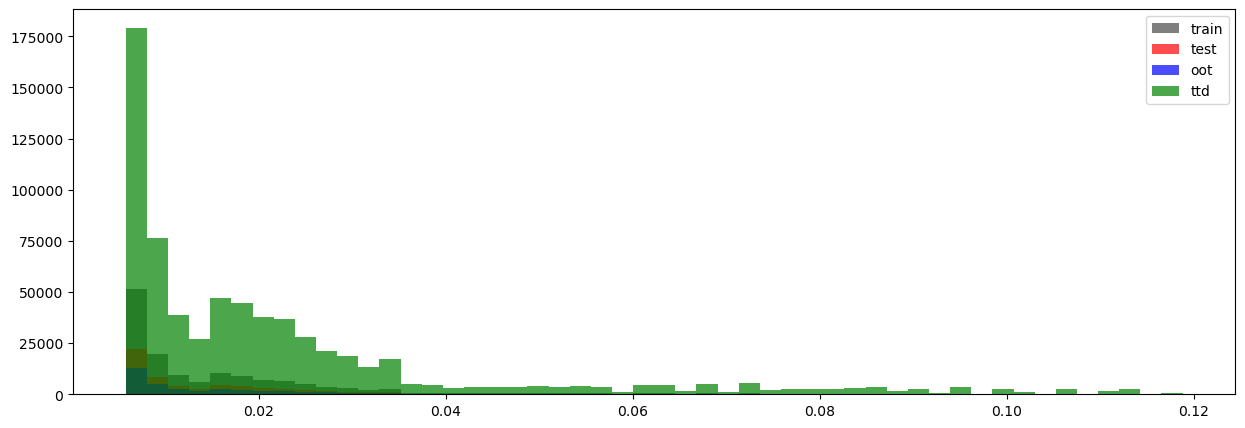

In [113]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15, 5))
plt.hist(Train['p1'], bins= 50, label= 'train', color= 'black', alpha= 0.5)
plt.hist(Test['p1'], bins= 50, label= 'test', color= 'red', alpha= 0.7)
plt.hist(Oot['p1'], bins= 50, label= 'oot', color= 'blue', alpha= 0.7)
plt.hist(TTD['p1'], bins= 50, label= 'ttd', color= 'green', alpha= 0.7)
plt.legend()
plt.show()

In [114]:
Train['p1'].value_counts(dropna= False).head()

p1
0.005781    11262
0.006115     6581
0.006502     4378
0.006465     3804
0.006113     3221
Name: count, dtype: int64

In [115]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     141943
[1]       4543
[2]        337
[-1]        32
Name: count, dtype: int64
bankruptcystatus
[0]     60829
[1]      1941
[2]       157
[-1]       11
Name: count, dtype: int64


In [116]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [117]:
df_bv= pd.DataFrame()

for col in col_list:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_P1', 'Train_Count']
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_P1', 'Test_Count']
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

assetownership
inquiryauto12month
inquiryshortterm12month
sourcenonderogcount12month
assetpropevercount
inquirytelcom12month
sourcenonderogcount
derogcount
addrlastmovetaxratiodiff
inquirynonshortterm12month
addrcurrenttaxmarketvalue
addrinputtaxvalue
criminalnonfelonycount
evictioncount
derogcount12month
addrinputtimenewest
addrprevioustimeoldest
educationprogramattended
criminalfelonycount
educationattendance
addrinputlengthofres
addrcurrentblockratio
addrinputtaxmarketvalue
bankruptcydismissed24month
addrchangecount03month
inquirycollections12month
inquirybanking12month
bankruptcychapter
addrinputsubjectcount
addrchangecount24month
addrcurrentdeedmailing
addrinputdeedmailing
addrchangecount06month
lienjudgmentcount
lienjudgmentsmallclaimscount
addrpreviouslengthofres
bankruptcystatus
assetpropnewestmortgagetype
bankruptcycount24month
assetproppurchasetimeoldest
assetproppurchasetimenewest
criminalnonfelonycount12month
assetpersonalcount
addrchangecount60month
addrinputtimelastsale
a

In [118]:
pd.options.display.max_rows= 1000
df_bv

,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetownership,[0],1606.0,0.029652,0.030768,54162,691.0,0.029889,0.030935,23119.0,Yes
1,assetownership,[1],621.0,0.006700,0.009325,92693,268.0,0.006730,0.009332,39819.0,Yes
2,inquiryauto12month,[0],1496.0,0.011491,0.013158,130194,647.0,0.011612,0.013132,55716.0,Yes
3,inquiryauto12month,[1],731.0,0.043875,0.049080,16661,312.0,0.043201,0.049174,7222.0,Yes
4,inquiryshortterm12month,[0],2005.0,0.013959,0.016789,143630,882.0,0.014330,0.016834,61551.0,Yes
5,inquiryshortterm12month,[1],222.0,0.068837,0.037018,3225,77.0,0.055516,0.036490,1387.0,Yes
6,sourcenonderogcount12month,"[-inf, 2.0)",1730.0,0.023668,0.022430,73094,726.0,0.023263,0.022470,31209.0,Yes
7,sourcenonderogcount12month,"[2.0, inf)",497.0,0.006738,0.012084,73761,233.0,0.007343,0.012150,31729.0,Yes
8,assetpropevercount,"[-inf, 1.0)",1526.0,0.030046,0.031143,50788,663.0,0.030656,0.031324,21627.0,Yes
9,assetpropevercount,"[1.0, 2.0)",445.0,0.008564,0.010147,51963,204.0,0.009101,0.010200,22414.0,Yes


In [120]:
for client in Train['client'].unique():
    print(client)
    get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
                  data= Train[Train['client']== client], 
                  data_h2o= train_h2o[train_h2o['client']== client], 
                  target= 'bad_flag', 
                  cols_tuple= col_tuple_pass, 
                  score_col= 'p1', 
                  weight= 'conwt')
    

Tower
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
30041 572.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.020937,0.117849,0.038094,6009,5704.0,305.0,5.08,20.0,19.36,53.32,33.96
1,0.012675,0.020937,0.016871,6008,5878.0,130.0,2.16,40.0,39.30,76.05,36.75
2,0.007864,0.012670,0.009584,6008,5936.0,72.0,1.20,60.0,59.45,88.64,29.19
3,0.006465,0.007864,0.006934,6008,5963.0,45.0,0.75,80.0,79.68,96.50,16.82
4,0.005781,0.006465,0.006032,6008,5988.0,20.0,0.33,100.0,100.00,100.00,0.00


{'Gini': 46.69, 'KS': 36.75}
GESA
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19768 402.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.026784,0.118822,0.048307,3954,3760.0,194.0,4.91,20.0,19.42,48.26,28.84
1,0.018285,0.026696,0.022092,3954,3854.0,100.0,2.53,40.0,39.32,73.13,33.81
2,0.010411,0.018285,0.014599,3953,3879.0,74.0,1.87,60.0,59.35,91.54,32.19
3,0.006877,0.010407,0.008262,3954,3930.0,24.0,0.61,80.0,79.64,97.51,17.87
4,0.005781,0.006877,0.006223,3953,3943.0,10.0,0.25,100.0,100.00,100.00,0.00


{'Gini': 45.08, 'KS': 33.81}
Hawaii
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
1438 3.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.025076,0.112397,0.039715,288,287.0,1.0,0.35,20.03,20.00,33.33,13.33
1,0.019270,0.025076,0.021440,288,288.0,0.0,0.00,40.06,40.07,33.33,6.74
2,0.013622,0.019270,0.016637,287,286.0,1.0,0.35,60.01,60.00,66.67,6.67
3,0.008488,0.013600,0.010331,288,288.0,0.0,0.00,80.04,80.07,66.67,13.40
4,0.005781,0.008488,0.007146,287,286.0,1.0,0.35,100.00,100.00,100.00,0.00


{'Gini': -0.05, 'KS': 13.4}
Guardian
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19177 268.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.028680,0.118822,0.055765,3836,3696.0,140.0,3.65,20.0,19.55,52.24,32.69
1,0.018383,0.028680,0.022717,3835,3761.0,74.0,1.93,40.0,39.44,79.85,40.41
2,0.010309,0.018363,0.014222,3836,3810.0,26.0,0.68,60.0,59.59,89.55,29.96
3,0.007372,0.010309,0.008620,3835,3818.0,17.0,0.44,80.0,79.78,95.90,16.12
4,0.005781,0.007372,0.006383,3835,3824.0,11.0,0.29,100.0,100.00,100.00,0.00


{'Gini': 47.67, 'KS': 40.41}
SECU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
12804 320.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.025598,0.118822,0.051106,2561,2380.0,181.0,7.07,20.00,19.06,56.56,37.50
1,0.017013,0.025588,0.020499,2561,2481.0,80.0,3.12,40.00,38.94,81.56,42.62
2,0.008551,0.017013,0.012900,2561,2525.0,36.0,1.41,60.00,59.16,92.81,33.65
3,0.006465,0.008551,0.007265,2561,2543.0,18.0,0.70,80.01,79.53,98.44,18.91
4,0.005781,0.006465,0.006079,2560,2555.0,5.0,0.20,100.00,100.00,100.00,0.00


{'Gini': 53.06999999999999, 'KS': 42.62}
Arkansas
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
27867 167.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019222,0.117849,0.035783,5574,5484.0,90.0,1.61,20.0,19.80,53.89,34.09
1,0.010921,0.019217,0.014817,5573,5535.0,38.0,0.68,40.0,39.78,76.65,36.87
2,0.008086,0.010921,0.009177,5574,5559.0,15.0,0.27,60.0,59.85,85.63,25.78
3,0.006366,0.008086,0.007183,5573,5558.0,15.0,0.27,80.0,79.91,94.61,14.70
4,0.005781,0.006366,0.005951,5573,5564.0,9.0,0.16,100.0,100.00,100.00,0.00


{'Gini': 44.58, 'KS': 36.87}
Numerica
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
18091 297.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023032,0.118822,0.038226,3619,3491.0,128.0,3.54,20.0,19.62,43.10,23.48
1,0.015145,0.023032,0.018848,3618,3527.0,91.0,2.52,40.0,39.44,73.74,34.30
2,0.008766,0.015145,0.011393,3618,3580.0,38.0,1.05,60.0,59.56,86.53,26.97
3,0.006877,0.008766,0.007773,3618,3591.0,27.0,0.75,80.0,79.74,95.62,15.88
4,0.005781,0.006877,0.006257,3618,3605.0,13.0,0.36,100.0,100.00,100.00,0.00


{'Gini': 40.25, 'KS': 34.3}
CPM
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6702 94.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.020379,0.118822,0.038004,1341,1293.0,48.0,3.58,20.01,19.57,51.06,31.49
1,0.012474,0.020379,0.016268,1340,1316.0,24.0,1.79,40.00,39.48,76.60,37.12
2,0.008086,0.012474,0.009771,1341,1330.0,11.0,0.82,60.01,59.61,88.30,28.69
3,0.006502,0.008086,0.007206,1340,1334.0,6.0,0.45,80.01,79.80,94.68,14.88
4,0.005781,0.006502,0.006000,1340,1335.0,5.0,0.37,100.00,100.00,100.00,0.00


{'Gini': 44.87, 'KS': 37.12}
Bethpage
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
8328 63.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.020510,0.112397,0.036590,1666,1639.0,27.0,1.62,20.00,19.83,42.86,23.03
1,0.014359,0.020510,0.017121,1666,1656.0,10.0,0.60,40.01,39.87,58.73,18.86
2,0.007796,0.014359,0.010566,1665,1652.0,13.0,0.78,60.00,59.85,79.37,19.52
3,0.006115,0.007796,0.006762,1666,1658.0,8.0,0.48,80.01,79.92,92.06,12.14
4,0.005781,0.006115,0.005858,1665,1660.0,5.0,0.30,100.00,100.00,100.00,0.00


{'Gini': 29.42, 'KS': 23.03}
HFCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
2044 33.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.021809,0.112397,0.038627,409,398.0,11.0,2.69,20.01,19.79,33.33,13.54
1,0.014947,0.021791,0.017956,409,397.0,12.0,2.93,40.02,39.53,69.70,30.17
2,0.008086,0.014870,0.010856,409,402.0,7.0,1.71,60.03,59.52,90.91,31.39
3,0.006366,0.008086,0.007077,409,407.0,2.0,0.49,80.04,79.76,96.97,17.21
4,0.005781,0.006354,0.005864,408,407.0,1.0,0.25,100.00,100.00,100.00,0.00


{'Gini': 36.93, 'KS': 31.39}
NCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
595 8.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024793,0.111471,0.046184,120,114.0,6.0,5.00,20.17,19.42,75.0,55.58
1,0.017158,0.024793,0.020246,118,116.0,2.0,1.69,40.00,39.18,100.0,60.82
2,0.009129,0.017109,0.013445,120,120.0,0.0,0.00,60.17,59.63,100.0,40.37
3,0.006575,0.009092,0.007812,119,119.0,0.0,0.00,80.17,79.90,100.0,20.10
4,0.005781,0.006575,0.006063,118,118.0,0.0,0.00,100.00,100.00,100.0,0.00


{'Gini': 70.78, 'KS': 60.82}


### Basic Checks

In [121]:
TTD['funded_flag'].sum(), Train['funded_flag'].sum(), Test['funded_flag'].sum()

(200148.0, 146855.0, 62938.0)

In [122]:
TTD['id']= TTD['unique_id']+TTD['client']
Train['id']= Train['unique_id']+Train['client']
Test['id']= Test['unique_id']+Test['client']
Oot['id']= Oot['unique_id']+Oot['client']

In [123]:
Train[(Train['id'].isin(TTD['id'].unique())) & (Train['client']!= 'CPM')].shape, Train[Train['client']!='CPM'].shape

((140153, 147), (140153, 147))

In [124]:
Test[(Test['id'].isin(TTD['id'].unique())) & (Test['client']!= 'CPM')].shape, Test[Test['client']!='CPM'].shape

((59995, 147), (59995, 147))

In [125]:
Train[(Train['id'].isin(Test['id'].unique()))].shape

(0, 147)

In [126]:
TTD[TTD['id'].isin(Train[Train['client']!= 'CPM']['id'].unique())]['p1'].describe(), Train[Train['client']!= 'CPM']['p1'].describe()

(count    140153.000000
 mean          0.017319
 std           0.017059
 min           0.005781
 25%           0.006877
 50%           0.010642
 75%           0.020577
 max           0.118822
 Name: p1, dtype: float64,
 count    140153.000000
 mean          0.017319
 std           0.017059
 min           0.005781
 25%           0.006877
 50%           0.010642
 75%           0.020577
 max           0.118822
 Name: p1, dtype: float64)

In [127]:
Train['client'].value_counts(dropna= False)

client
Tower       30041
Arkansas    27867
GESA        19768
Guardian    19177
Numerica    18091
SECU        12804
Bethpage     8328
CPM          6702
HFCU         2044
Hawaii       1438
NCU           595
Name: count, dtype: int64

In [129]:
import datetime
pref= 'With_LDA'
# Train[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Train_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# Test[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Test_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# Oot[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Oot_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# TTD[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_TTD_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)

In [130]:
TTD['fico_cut']= np.where(((TTD['fico_pb'].isnull()) |(TTD['fico_pb']<300)),"h.Missing",
                        np.where((TTD['fico_pb']>=300) &(TTD['fico_pb']<550),"a.300-550",
                                 np.where((TTD['fico_pb']>=550) &(TTD['fico_pb']<600),"a.550-600",
                                np.where((TTD['fico_pb']>=600) &(TTD['fico_pb']<630),"b.600-629",
                                    np.where((TTD['fico_pb']>=630) &(TTD['fico_pb']<660),"c.630-659",
                                        np.where((TTD['fico_pb']>=660) &(TTD['fico_pb']<690),"d.660-689",
                                            np.where((TTD['fico_pb']>=690) &(TTD['fico_pb']<715),"e.690-714",
                                                np.where((TTD['fico_pb']>=715) & (TTD['fico_pb']<740),"f.715-739",
                                                    np.where((TTD['fico_pb']>=740),"g.740+","h.Missing")))))))))

In [131]:
TTD.groupby('fico_cut').agg(
    ttd= ('unique_id', 'count'),
    approved= ('approve_flag', 'sum'),
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    avg_pd= ('p1', 'mean')
)

,ttd,approved,funded,bad,avg_pd
fico_cut,,,,,
a.300-550,35333,2873.0,1857.0,126.0,0.040888
a.550-600,52785,13360.0,5376.0,346.0,0.035803
b.600-629,57138,23516.0,7940.0,386.0,0.031109
c.630-659,78628,39076.0,15179.0,554.0,0.026482
d.660-689,90338,52831.0,24815.0,511.0,0.022200
e.690-714,73120,48229.0,23877.0,300.0,0.019063
f.715-739,62889,45175.0,23083.0,186.0,0.017347
g.740+,199076,167515.0,93215.0,243.0,0.012530
h.Missing,35908,9030.0,4806.0,395.0,0.031778


In [132]:
TTD.shape

(685215, 148)